In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
color_pal = sns.color_palette()
import itertools

from statsmodels.tsa.stattools import adfuller

from statsmodels.tsa.stattools import acf 
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.stattools import pacf 
from statsmodels.graphics.tsaplots import plot_pacf

from statsmodels.tsa.seasonal import seasonal_decompose

from statsmodels.tsa.arima_process import arma_generate_sample

from statsmodels.tsa.arima.model import ARIMA

import pmdarima as pm
from pmdarima import model_selection

import xgboost as xgb
from xgboost import plot_importance, plot_tree
from sklearn.metrics import mean_squared_error, mean_absolute_error


In [4]:
data = pd.read_csv('./data/zillow_data.csv')

In [56]:
data.head()

,RegionID,RegionName,City,State,Metro,CountyName,SizeRank,1996-04,1996-05,1996-06,...,2017-07,2017-08,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04
0,84654,60657,Chicago,IL,Chicago,Cook,1,334200.0,335400.0,336500.0,...,1005500,1007500,1007800,1009600,1013300,1018700,1024400,1030700,1033800,1030600
1,90668,75070,McKinney,TX,Dallas-Fort Worth,Collin,2,235700.0,236900.0,236700.0,...,308000,310000,312500,314100,315000,316600,318100,319600,321100,321800
2,91982,77494,Katy,TX,Houston,Harris,3,210400.0,212200.0,212200.0,...,321000,320600,320200,320400,320800,321200,321200,323000,326900,329900
3,84616,60614,Chicago,IL,Chicago,Cook,4,498100.0,500900.0,503100.0,...,1289800,1287700,1287400,1291500,1296600,1299000,1302700,1306400,1308500,1307000
4,93144,79936,El Paso,TX,El Paso,El Paso,5,77300.0,77300.0,77300.0,...,119100,119400,120000,120300,120300,120300,120300,120500,121000,121500


# Step 2: Data Preprocessing

In [12]:
top_row = data.iloc[:1]

In [13]:
label_cols = list(data.columns.values[:7])

In [7]:
df_melted = pd.melt(data, id_vars=['RegionID', 'RegionName', 'City', 'State', 'Metro', 'CountyName',
       'SizeRank'], value_vars=['1996-04', '1996-05', '1996-06', '1996-07', '1996-08',
       '1996-09', '1996-10', '1996-11', '1996-12', '1997-01', '1997-02',
       '1997-03', '1997-04', '1997-05', '1997-06', '1997-07', '1997-08',
       '1997-09', '1997-10', '1997-11', '1997-12', '1998-01', '1998-02',
       '1998-03', '1998-04', '1998-05', '1998-06', '1998-07', '1998-08',
       '1998-09', '1998-10', '1998-11', '1998-12', '1999-01', '1999-02',
       '1999-03', '1999-04', '1999-05', '1999-06', '1999-07', '1999-08',
       '1999-09', '1999-10', '1999-11', '1999-12', '2000-01', '2000-02',
       '2000-03', '2000-04', '2000-05', '2000-06', '2000-07', '2000-08',
       '2000-09', '2000-10', '2000-11', '2000-12', '2001-01', '2001-02',
       '2001-03', '2001-04', '2001-05', '2001-06', '2001-07', '2001-08',
       '2001-09', '2001-10', '2001-11', '2001-12', '2002-01', '2002-02',
       '2002-03', '2002-04', '2002-05', '2002-06', '2002-07', '2002-08',
       '2002-09', '2002-10', '2002-11', '2002-12', '2003-01', '2003-02',
       '2003-03', '2003-04', '2003-05', '2003-06', '2003-07', '2003-08',
       '2003-09', '2003-10', '2003-11', '2003-12', '2004-01', '2004-02',
       '2004-03', '2004-04', '2004-05', '2004-06', '2004-07', '2004-08',
       '2004-09', '2004-10', '2004-11', '2004-12', '2005-01', '2005-02',
       '2005-03', '2005-04', '2005-05', '2005-06', '2005-07', '2005-08',
       '2005-09', '2005-10', '2005-11', '2005-12', '2006-01', '2006-02',
       '2006-03', '2006-04', '2006-05', '2006-06', '2006-07', '2006-08',
       '2006-09', '2006-10', '2006-11', '2006-12', '2007-01', '2007-02',
       '2007-03', '2007-04', '2007-05', '2007-06', '2007-07', '2007-08',
       '2007-09', '2007-10', '2007-11', '2007-12', '2008-01', '2008-02',
       '2008-03', '2008-04', '2008-05', '2008-06', '2008-07', '2008-08',
       '2008-09', '2008-10', '2008-11', '2008-12', '2009-01', '2009-02',
       '2009-03', '2009-04', '2009-05', '2009-06', '2009-07', '2009-08',
       '2009-09', '2009-10', '2009-11', '2009-12', '2010-01', '2010-02',
       '2010-03', '2010-04', '2010-05', '2010-06', '2010-07', '2010-08',
       '2010-09', '2010-10', '2010-11', '2010-12', '2011-01', '2011-02',
       '2011-03', '2011-04', '2011-05', '2011-06', '2011-07', '2011-08',
       '2011-09', '2011-10', '2011-11', '2011-12', '2012-01', '2012-02',
       '2012-03', '2012-04', '2012-05', '2012-06', '2012-07', '2012-08',
       '2012-09', '2012-10', '2012-11', '2012-12', '2013-01', '2013-02',
       '2013-03', '2013-04', '2013-05', '2013-06', '2013-07', '2013-08',
       '2013-09', '2013-10', '2013-11', '2013-12', '2014-01', '2014-02',
       '2014-03', '2014-04', '2014-05', '2014-06', '2014-07', '2014-08',
       '2014-09', '2014-10', '2014-11', '2014-12', '2015-01', '2015-02',
       '2015-03', '2015-04', '2015-05', '2015-06', '2015-07', '2015-08',
       '2015-09', '2015-10', '2015-11', '2015-12', '2016-01', '2016-02',
       '2016-03', '2016-04', '2016-05', '2016-06', '2016-07', '2016-08',
       '2016-09', '2016-10', '2016-11', '2016-12', '2017-01', '2017-02',
       '2017-03', '2017-04', '2017-05', '2017-06', '2017-07', '2017-08',
       '2017-09', '2017-10', '2017-11', '2017-12', '2018-01', '2018-02',
       '2018-03', '2018-04'], var_name='Date', value_name='Price')

In [16]:
df_melted[df_melted['CountyName'] == 'Cook']

,RegionID,RegionName,City,State,Metro,CountyName,SizeRank,Date,Price
0,84654,60657,Chicago,IL,Chicago,Cook,1,1996-04,334200.0
3,84616,60614,Chicago,IL,Chicago,Cook,4,1996-04,498100.0
7,84640,60640,Chicago,IL,Chicago,Cook,8,1996-04,216500.0
16,84646,60647,Chicago,IL,Chicago,Cook,17,1996-04,122700.0
19,84620,60618,Chicago,IL,Chicago,Cook,20,1996-04,142600.0
...,...,...,...,...,...,...,...,...,...
3898107,84412,60163,Berkeley,IL,Chicago,Cook,11236,2018-04,180100.0
3898460,84446,60203,Evanston,IL,Chicago,Cook,11589,2018-04,402000.0
3899588,84414,60165,Stone Park,IL,Chicago,Cook,12717,2018-04,156000.0
3900031,84527,60476,Thornton,IL,Chicago,Cook,13160,2018-04,102400.0


In [8]:
df_melted

,RegionID,RegionName,City,State,Metro,CountyName,SizeRank,Date,Price
0,84654,60657,Chicago,IL,Chicago,Cook,1,1996-04,334200.0
1,90668,75070,McKinney,TX,Dallas-Fort Worth,Collin,2,1996-04,235700.0
2,91982,77494,Katy,TX,Houston,Harris,3,1996-04,210400.0
3,84616,60614,Chicago,IL,Chicago,Cook,4,1996-04,498100.0
4,93144,79936,El Paso,TX,El Paso,El Paso,5,1996-04,77300.0
...,...,...,...,...,...,...,...,...,...
3901590,58333,1338,Ashfield,MA,Greenfield Town,Franklin,14719,2018-04,209300.0
3901591,59107,3293,Woodstock,NH,Claremont,Grafton,14720,2018-04,225800.0
3901592,75672,40404,Berea,KY,Richmond,Madison,14721,2018-04,133400.0
3901593,93733,81225,Mount Crested Butte,CO,NaN,Gunnison,14722,2018-04,664400.0


In [9]:
df_mean = df_melted.groupby(['Date']).mean()

/var/folders/d9/xswmylg9377__r4x6b40670h0000gn/T/ipykernel_1343/705390131.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_mean = df_melted.groupby(['Date']).mean()


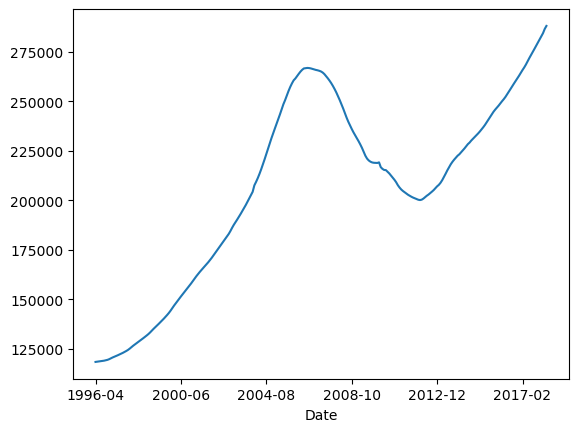

In [10]:
df_mean["Price"].plot();

In [11]:
from statsmodels.graphics.tsaplots import plot_acf

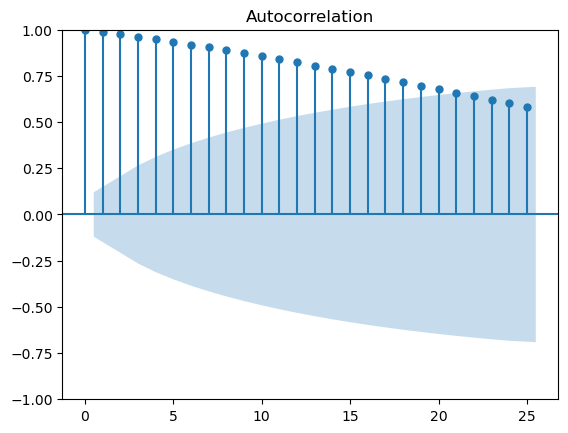

In [166]:
plot_acf(df_mean["Price"])
plt.show()

In [167]:
from statsmodels.tsa.stattools import pacf 
from statsmodels.graphics.tsaplots import plot_pacf

/Users/eitan/anaconda3/envs/Number41/lib/python3.11/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


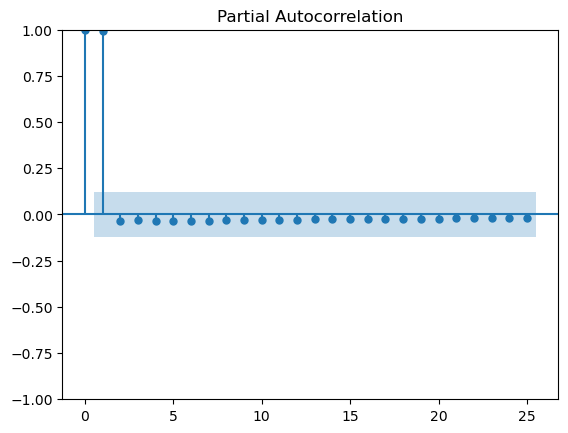

In [169]:
plot_pacf(df_mean["Price"])
plt.show()

In [159]:
df_mean_diff = df_mean['Price'].diff()

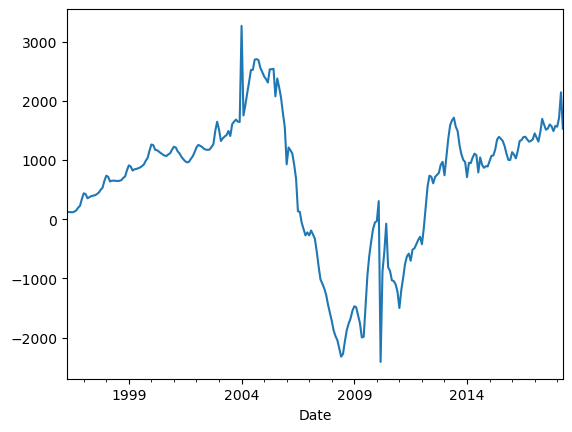

In [162]:
df_mean_diff.plot();

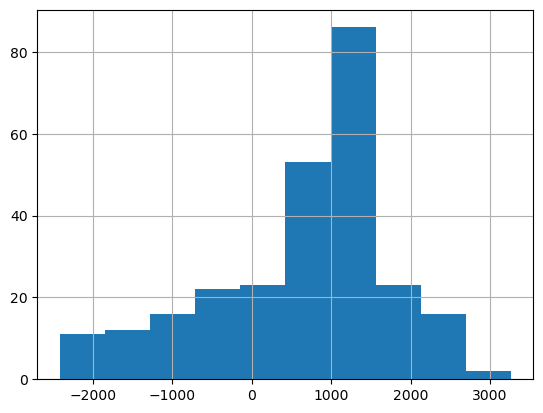

In [163]:
df_mean_diff.hist()
plt.show()

In [12]:
df_melted['Date'] = pd.to_datetime(df_melted['Date'])

In [13]:
df_melted.set_index('Date', inplace = True)

In [19]:
df_melted.sort_values(by=['SizeRank'])

,RegionID,RegionName,City,State,Metro,CountyName,SizeRank,Price
Date,,,,,,,,
1996-04-01,84654,60657,Chicago,IL,Chicago,Cook,1,334200.0
2008-11-01,84654,60657,Chicago,IL,Chicago,Cook,1,824800.0
2009-12-01,84654,60657,Chicago,IL,Chicago,Cook,1,774600.0
2004-09-01,84654,60657,Chicago,IL,Chicago,Cook,1,798200.0
2005-10-01,84654,60657,Chicago,IL,Chicago,Cook,1,870700.0
...,...,...,...,...,...,...,...,...
2008-07-01,95851,89155,Mesquite,NV,Las Vegas,Clark,14723,316000.0
2005-12-01,95851,89155,Mesquite,NV,Las Vegas,Clark,14723,443800.0
2015-03-01,95851,89155,Mesquite,NV,Las Vegas,Clark,14723,289100.0


In [ ]:
df_melted.loc

In [123]:
df_chicago = df_melted[df_melted['City'] == 'Chicago']

In [16]:
df_chicago.sort_values(by=['RegionName', 'Date'])

,RegionID,RegionName,City,State,Metro,CountyName,SizeRank,Price
Date,,,,,,,,
1996-04-01,84607,60605,Chicago,IL,Chicago,Cook,1361,293500.0
1996-05-01,84607,60605,Chicago,IL,Chicago,Cook,1361,293000.0
1996-06-01,84607,60605,Chicago,IL,Chicago,Cook,1361,292500.0
1996-07-01,84607,60605,Chicago,IL,Chicago,Cook,1361,291700.0
1996-08-01,84607,60605,Chicago,IL,Chicago,Cook,1361,290900.0
...,...,...,...,...,...,...,...,...
2017-12-01,84656,60660,Chicago,IL,Chicago,Cook,348,517700.0
2018-01-01,84656,60660,Chicago,IL,Chicago,Cook,348,521500.0
2018-02-01,84656,60660,Chicago,IL,Chicago,Cook,348,524100.0


In [171]:
df_chicago

,Date,RegionID,RegionName,City,State,Metro,CountyName,SizeRank,Price
0,1996-04-01,84654,60657,Chicago,IL,Chicago,Cook,1,334200.0
3,1996-04-01,84616,60614,Chicago,IL,Chicago,Cook,4,498100.0
7,1996-04-01,84640,60640,Chicago,IL,Chicago,Cook,8,216500.0
16,1996-04-01,84646,60647,Chicago,IL,Chicago,Cook,17,122700.0
19,1996-04-01,84620,60618,Chicago,IL,Chicago,Cook,20,142600.0
...,...,...,...,...,...,...,...,...,...
3890028,2018-04-01,84653,60656,Chicago,IL,Chicago,Cook,3157,304000.0
3890832,2018-04-01,84652,60655,Chicago,IL,Chicago,Cook,3961,232600.0
3890912,2018-04-01,84645,60646,Chicago,IL,Chicago,Cook,4041,401300.0
3891234,2018-04-01,399713,60642,Chicago,IL,Chicago,Cook,4363,604400.0


In [116]:
chi_mean = df_chicago.groupby(['City', 'Date']).mean()

/var/folders/d9/xswmylg9377__r4x6b40670h0000gn/T/ipykernel_1720/2759028472.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  chi_mean = df_chicago.groupby(['City', 'Date']).mean()


In [123]:
chi_mean.reset_index(inplace = True)

In [130]:
chi_mean.set_index('Date', inplace = True)

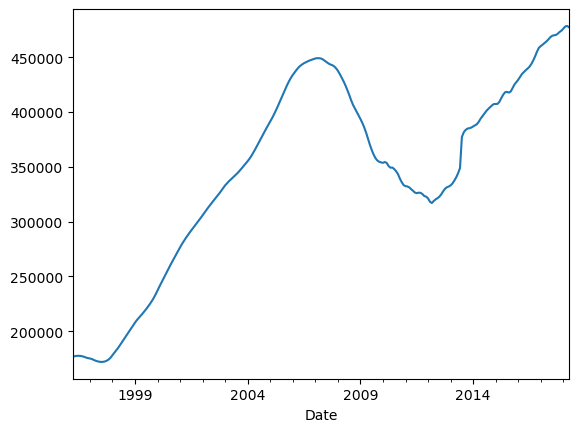

In [132]:
chi_mean['Price'].plot();

In [139]:
chi_mean_first_difference = chi_mean['Price'].diff()

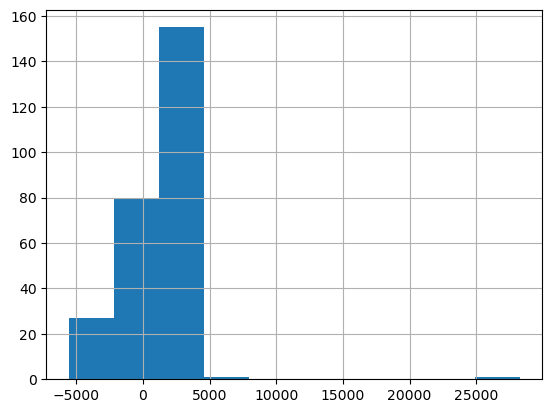

In [144]:
chi_mean_first_difference.hist()
plt.show()

In [143]:
sorted(chi_mean.index)

[Timestamp('1996-04-01 00:00:00'),
 Timestamp('1996-05-01 00:00:00'),
 Timestamp('1996-06-01 00:00:00'),
 Timestamp('1996-07-01 00:00:00'),
 Timestamp('1996-08-01 00:00:00'),
 Timestamp('1996-09-01 00:00:00'),
 Timestamp('1996-10-01 00:00:00'),
 Timestamp('1996-11-01 00:00:00'),
 Timestamp('1996-12-01 00:00:00'),
 Timestamp('1997-01-01 00:00:00'),
 Timestamp('1997-02-01 00:00:00'),
 Timestamp('1997-03-01 00:00:00'),
 Timestamp('1997-04-01 00:00:00'),
 Timestamp('1997-05-01 00:00:00'),
 Timestamp('1997-06-01 00:00:00'),
 Timestamp('1997-07-01 00:00:00'),
 Timestamp('1997-08-01 00:00:00'),
 Timestamp('1997-09-01 00:00:00'),
 Timestamp('1997-10-01 00:00:00'),
 Timestamp('1997-11-01 00:00:00'),
 Timestamp('1997-12-01 00:00:00'),
 Timestamp('1998-01-01 00:00:00'),
 Timestamp('1998-02-01 00:00:00'),
 Timestamp('1998-03-01 00:00:00'),
 Timestamp('1998-04-01 00:00:00'),
 Timestamp('1998-05-01 00:00:00'),
 Timestamp('1998-06-01 00:00:00'),
 Timestamp('1998-07-01 00:00:00'),
 Timestamp('1998-08-

<Axes: xlabel='Date'>

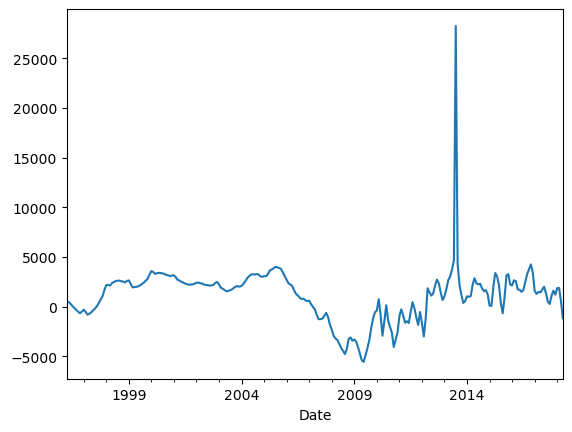

In [140]:
chi_mean_first_difference.plot()

In [122]:
chi_mean

RegionID    RegionName     SizeRank          Price
City    Date                                                              
Chicago 1996-04-01  92317.829268  60633.097561  1266.536585  176757.500000
        1996-05-01  92317.829268  60633.097561  1266.536585  177220.000000
        1996-06-01  92317.829268  60633.097561  1266.536585  177500.000000
        1996-07-01  92317.829268  60633.097561  1266.536585  177560.000000
        1996-08-01  92317.829268  60633.097561  1266.536585  177435.000000
...                          ...           ...          ...            ...
        2017-12-01  92317.829268  60633.097561  1266.536585  474153.658537
        2018-01-01  92317.829268  60633.097561  1266.536585  476026.829268
        2018-02-01  92317.829268  60633.097561  1266.536585  477909.756098
        2018-03-01  92317.829268  60633.097561  1266.536585  478475.609756
        2018-04-01  92317.829268  60633.097561  1266.536585  477292.682927

[265 rows x 4 columns]

In [119]:
chi_mean_price = chi_mean(columns =['Date', 'Price'])

TypeError: 'DataFrame' object is not callable

In [113]:
chi_mean_price

""


In [96]:
chicago = df_chicago.groupby('City').mean()

/var/folders/d9/xswmylg9377__r4x6b40670h0000gn/T/ipykernel_1720/3104339859.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  chicago = df_chicago.groupby('City').mean()


In [99]:
chicago['Price']

City
Chicago    345709.823607
Name: Price, dtype: float64

In [58]:
chi_town_zip = df_melted[df_melted['RegionName'] == 60657]

In [62]:
chi_town_zip.set_index('Date', inplace = True)

In [72]:
color_pal

[(0.12156862745098039, 0.4666666666666667, 0.7058823529411765),
 (1.0, 0.4980392156862745, 0.054901960784313725),
 (0.17254901960784313, 0.6274509803921569, 0.17254901960784313),
 (0.8392156862745098, 0.15294117647058825, 0.1568627450980392),
 (0.5803921568627451, 0.403921568627451, 0.7411764705882353),
 (0.5490196078431373, 0.33725490196078434, 0.29411764705882354),
 (0.8901960784313725, 0.4666666666666667, 0.7607843137254902),
 (0.4980392156862745, 0.4980392156862745, 0.4980392156862745),
 (0.7372549019607844, 0.7411764705882353, 0.13333333333333333),
 (0.09019607843137255, 0.7450980392156863, 0.8117647058823529)]

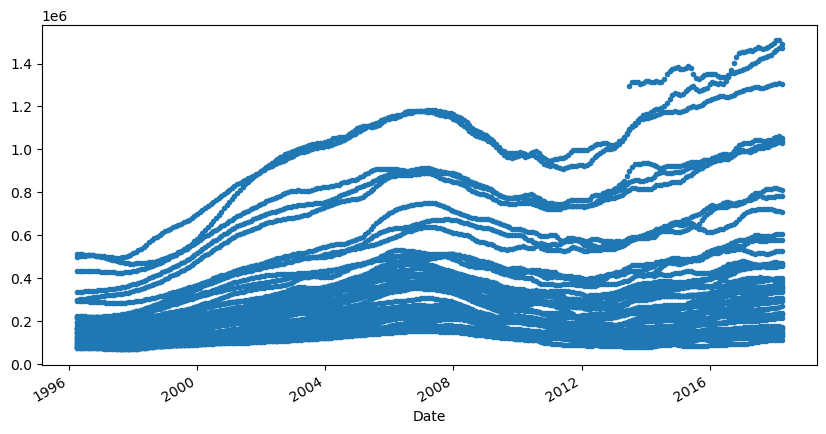

In [88]:
fix, ax = plt.subplots(figsize = (10,5))

#chi_town_zip['Price'].plot(style = '.', color = color_pal[1], title = 'Chicago Zip Pricing')

df_chicago['Price'].plot(style = '.');

In [20]:
df_melted.sort_index()

,RegionID,RegionName,City,State,Metro,CountyName,SizeRank,Price
Date,,,,,,,,
1996-04-01,84654,60657,Chicago,IL,Chicago,Cook,1,334200.0
1996-04-01,90668,75070,McKinney,TX,Dallas-Fort Worth,Collin,2,235700.0
1996-04-01,91982,77494,Katy,TX,Houston,Harris,3,210400.0
1996-04-01,84616,60614,Chicago,IL,Chicago,Cook,4,498100.0
1996-04-01,93144,79936,El Paso,TX,El Paso,El Paso,5,77300.0
...,...,...,...,...,...,...,...,...
2018-04-01,58333,1338,Ashfield,MA,Greenfield Town,Franklin,14719,209300.0
2018-04-01,59107,3293,Woodstock,NH,Claremont,Grafton,14720,225800.0
2018-04-01,75672,40404,Berea,KY,Richmond,Madison,14721,133400.0


In [47]:
reset_inex.sort_values([ 'RegionName', 'Date'])

,Date,RegionID,RegionName,City,State,Metro,CountyName,SizeRank,Price
5850,1996-04-01,58196,1001,Agawam,MA,Springfield,Hampden,5851,113100.0
20573,1996-05-01,58196,1001,Agawam,MA,Springfield,Hampden,5851,112800.0
35296,1996-06-01,58196,1001,Agawam,MA,Springfield,Hampden,5851,112600.0
50019,1996-07-01,58196,1001,Agawam,MA,Springfield,Hampden,5851,112300.0
64742,1996-08-01,58196,1001,Agawam,MA,Springfield,Hampden,5851,112100.0
...,...,...,...,...,...,...,...,...,...
3835273,2017-12-01,100478,99901,Ketchikan,AK,Ketchikan,Ketchikan Gateway,7294,291900.0
3849996,2018-01-01,100478,99901,Ketchikan,AK,Ketchikan,Ketchikan Gateway,7294,294200.0
3864719,2018-02-01,100478,99901,Ketchikan,AK,Ketchikan,Ketchikan Gateway,7294,297500.0
3879442,2018-03-01,100478,99901,Ketchikan,AK,Ketchikan,Ketchikan Gateway,7294,302100.0


In [53]:
reset_inex.groupby(['RegionName', 'Price', 'Date']).mean()

/var/folders/d9/xswmylg9377__r4x6b40670h0000gn/T/ipykernel_1720/2759545741.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  reset_inex.groupby(['RegionName', 'Price', 'Date']).mean()


RegionID  SizeRank
RegionName Price    Date                          
1001       111700.0 1996-11-01   58196.0    5851.0
                    1996-12-01   58196.0    5851.0
           111800.0 1996-10-01   58196.0    5851.0
           111900.0 1996-09-01   58196.0    5851.0
                    1997-01-01   58196.0    5851.0
...                                  ...       ...
99901      291900.0 2017-12-01  100478.0    7294.0
           294200.0 2018-01-01  100478.0    7294.0
           297500.0 2018-02-01  100478.0    7294.0
           302100.0 2018-03-01  100478.0    7294.0
           305100.0 2018-04-01  100478.0    7294.0

[3744704 rows x 2 columns]

In [48]:
reset_inex.set_index('Date')

,RegionID,RegionName,City,State,Metro,CountyName,SizeRank,Price
Date,,,,,,,,
1996-04-01,84654,60657,Chicago,IL,Chicago,Cook,1,334200.0
1996-04-01,90668,75070,McKinney,TX,Dallas-Fort Worth,Collin,2,235700.0
1996-04-01,91982,77494,Katy,TX,Houston,Harris,3,210400.0
1996-04-01,84616,60614,Chicago,IL,Chicago,Cook,4,498100.0
1996-04-01,93144,79936,El Paso,TX,El Paso,El Paso,5,77300.0
...,...,...,...,...,...,...,...,...
2018-04-01,58333,1338,Ashfield,MA,Greenfield Town,Franklin,14719,209300.0
2018-04-01,59107,3293,Woodstock,NH,Claremont,Grafton,14720,225800.0
2018-04-01,75672,40404,Berea,KY,Richmond,Madison,14721,133400.0


In [41]:
reset_inex = df_melted

In [42]:
reset_inex.reset_index(inplace = True)

In [21]:
label_cols = data.columns.values[:7]

# Step 3: EDA and Visualization

In [ ]:
font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 22}

plt.rc('font', **font)

# NOTE: if you visualizations are too cluttered to read, try calling 'plt.gcf().autofmt_xdate()'!

plt.plot(data)

ConversionError: Failed to convert value(s) to axis units: array(['Chicago', 'McKinney', 'Katy', ..., 'Berea', 'Mount Crested Butte',
       'Mesquite'], dtype=object)

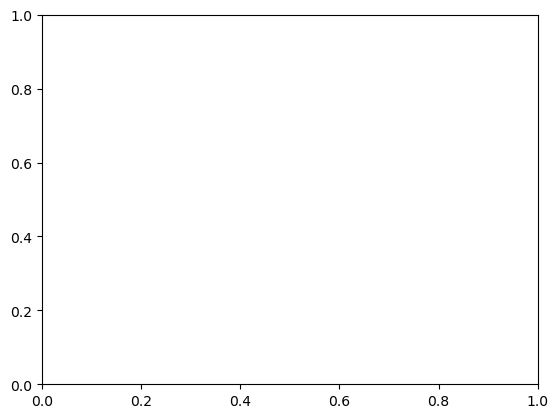

In [22]:
plt.plot(data)

# Step 4: Reshape from Wide to Long Format

In [4]:
def melt_data(df):
    """
    Takes the zillow_data dataset in wide form or a subset of the zillow_dataset.  
    Returns a long-form datetime dataframe 
    with the datetime column names as the index and the values as the 'values' column.
    
    If more than one row is passes in the wide-form dataset, the values column
    will be the mean of the values from the datetime columns in all of the rows.
    """
    
    melted = pd.melt(df, id_vars=['RegionName', 'RegionID', 'SizeRank', 'City', 'State', 'Metro', 'CountyName'], var_name='time')
    melted['time'] = pd.to_datetime(melted['time'], infer_datetime_format=True)
    melted = melted.dropna(subset=['value'])
    return melted.groupby('time').aggregate({'value':'mean'})

In [75]:
usa_mean = melt_data(data)

In [82]:
type(usa_mean)

pandas.core.frame.DataFrame

In [76]:
df_usa_mean

Date
1996-04-01    118299.123063
1996-05-01    118419.044139
1996-06-01    118537.423268
1996-07-01    118653.069278
1996-08-01    118780.254312
                  ...      
2017-12-01    281095.320247
2018-01-01    282657.060382
2018-02-01    284368.688447
2018-03-01    286511.376757
2018-04-01    288039.944305
Name: Price, Length: 265, dtype: float64

In [19]:
df_melted.index

DatetimeIndex(['1996-04-01', '1996-04-01', '1996-04-01', '1996-04-01',
               '1996-04-01', '1996-04-01', '1996-04-01', '1996-04-01',
               '1996-04-01', '1996-04-01',
               ...
               '2018-04-01', '2018-04-01', '2018-04-01', '2018-04-01',
               '2018-04-01', '2018-04-01', '2018-04-01', '2018-04-01',
               '2018-04-01', '2018-04-01'],
              dtype='datetime64[ns]', name='Date', length=3901595, freq=None)

In [67]:
df_usa_mean = df_melted.groupby('Date').mean()['Price']

/var/folders/d9/xswmylg9377__r4x6b40670h0000gn/T/ipykernel_1343/1427932459.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_usa_mean = df_melted.groupby('Date').mean()['Price']


In [81]:
type(df_usa_mean)

pandas.core.series.Series

In [83]:
usa_mean.index

DatetimeIndex(['1996-04-01', '1996-05-01', '1996-06-01', '1996-07-01',
               '1996-08-01', '1996-09-01', '1996-10-01', '1996-11-01',
               '1996-12-01', '1997-01-01',
               ...
               '2017-07-01', '2017-08-01', '2017-09-01', '2017-10-01',
               '2017-11-01', '2017-12-01', '2018-01-01', '2018-02-01',
               '2018-03-01', '2018-04-01'],
              dtype='datetime64[ns]', name='time', length=265, freq=None)

In [71]:
df_usa_mean

DatetimeIndex(['1996-04-01', '1996-05-01', '1996-06-01', '1996-07-01',
               '1996-08-01', '1996-09-01', '1996-10-01', '1996-11-01',
               '1996-12-01', '1997-01-01',
               ...
               '2017-07-01', '2017-08-01', '2017-09-01', '2017-10-01',
               '2017-11-01', '2017-12-01', '2018-01-01', '2018-02-01',
               '2018-03-01', '2018-04-01'],
              dtype='datetime64[ns]', name='Date', length=265, freq=None)

In [72]:
rolling_mean

DatetimeIndex(['1996-04-01', '1996-05-01', '1996-06-01', '1996-07-01',
               '1996-08-01', '1996-09-01', '1996-10-01', '1996-11-01',
               '1996-12-01', '1997-01-01',
               ...
               '2017-07-01', '2017-08-01', '2017-09-01', '2017-10-01',
               '2017-11-01', '2017-12-01', '2018-01-01', '2018-02-01',
               '2018-03-01', '2018-04-01'],
              dtype='datetime64[ns]', name='Date', length=265, freq=None)

In [84]:
rolling_mean = usa_mean.rolling(window = 6).mean()
rolling_std = usa_mean.rolling(window = 6).std()

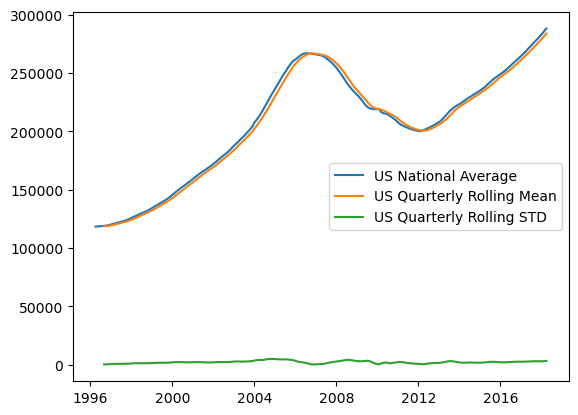

In [85]:
plt.plot(usa_mean, label = 'US National Average')
plt.plot(rolling_mean, label = 'US Quarterly Rolling Mean')
plt.plot(rolling_std, label = 'US Quarterly Rolling STD');

plt.legend();

In [40]:
from statsmodels.tsa.stattools import adfuller


In [86]:
adfuller(usa_mean)

(-1.8851445183777926,
 0.3390815439412539,
 2,
 262,
 {'1%': -3.455558114028747,
  '5%': -2.872635586277424,
  '10%': -2.572682677000175},
 3505.613476823798)

In [87]:
df_usa_mean_diff = usa_mean.diff()

In [88]:
diff_rolling_mean = df_usa_mean_diff.rolling(window = 6).mean()
dif_rolling_std = df_usa_mean_diff.rolling(window = 6).std()

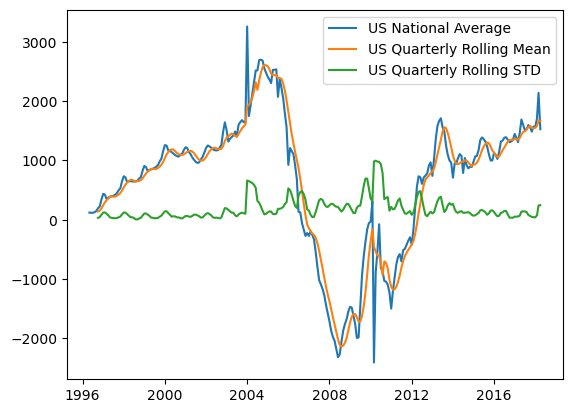

In [89]:
plt.plot(df_usa_mean_diff, label = 'US National Average')
plt.plot(diff_rolling_mean, label = 'US Quarterly Rolling Mean')
plt.plot(dif_rolling_std, label = 'US Quarterly Rolling STD');

plt.legend();

NameError: name 'plot_pacf' is not defined

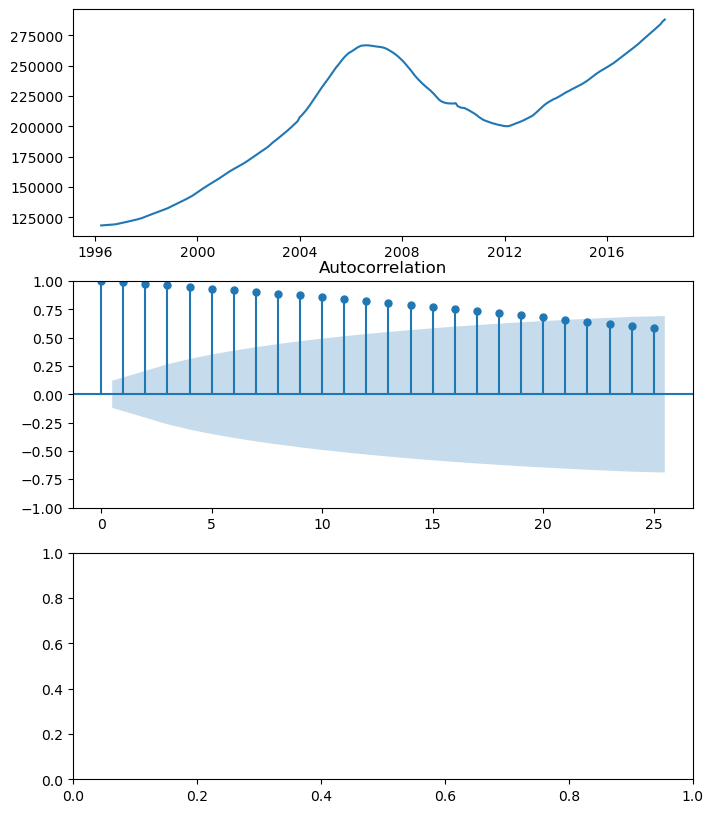

In [91]:
fig, ax = plt.subplots(3,1, figsize = (8,10))

ax[0].plot(usa_mean)
plot_acf(usa_mean, ax = ax[1])
plot_pacf(usa_mean, ax = ax[2])
plt.show()

In [97]:
df_usa_mean_diff = usa_mean.diff()

/Users/eitan/anaconda3/envs/Number41/lib/python3.11/site-packages/matplotlib/axes/_base.py:2503: UserWarning: Warning: converting a masked element to nan.
  xys = np.asarray(xys)
/Users/eitan/anaconda3/envs/Number41/lib/python3.11/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


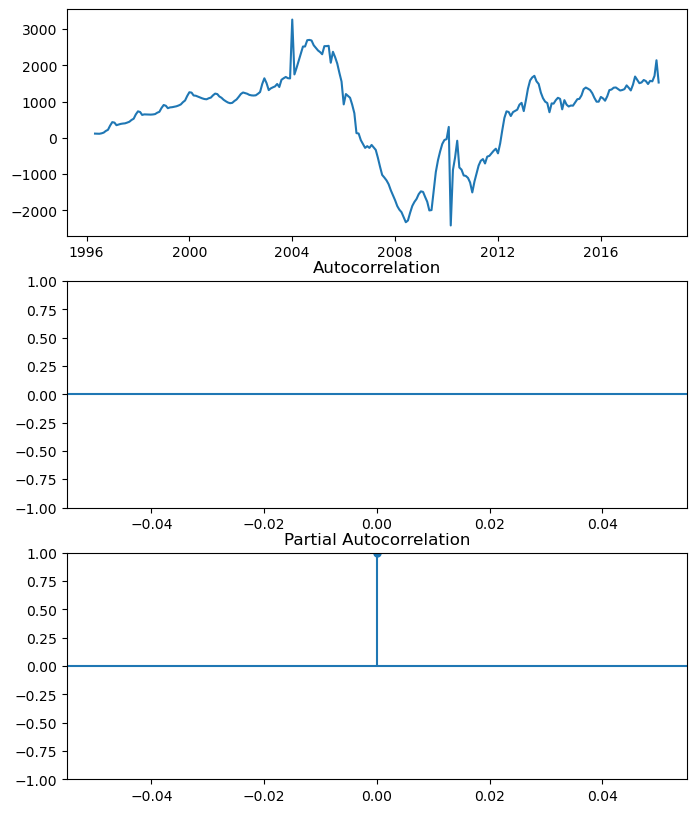

In [98]:
fig, ax = plt.subplots(3,1, figsize = (8,10))

ax[0].plot(df_usa_mean_diff)
plot_acf(df_usa_mean_diff, ax = ax[1])
plot_pacf(df_usa_mean_diff, ax = ax[2])
plt.show()

In [99]:
usa_mean

,value
time,
1996-04-01,118299.123063
1996-05-01,118419.044139
1996-06-01,118537.423268
1996-07-01,118653.069278
1996-08-01,118780.254312
...,...
2017-12-01,281095.320247
2018-01-01,282657.060382
2018-02-01,284368.688447


<Axes: xlabel='time'>

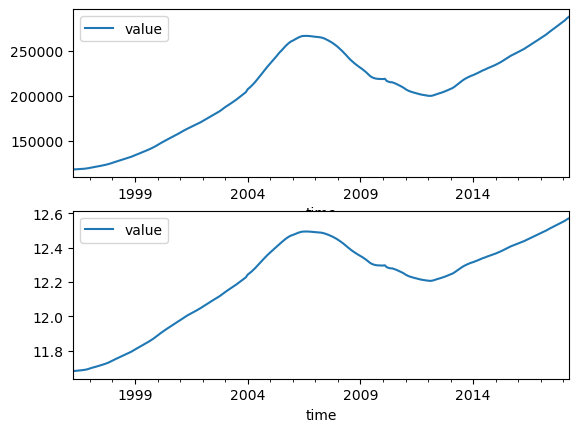

In [117]:
logged_data = np.log(usa_mean)

fix, ax = plt.subplots(2,1)
usa_mean.plot(ax = ax[0], label = 'US Mean Price')
logged_data.plot(ax = ax[1], label = 'US Log of Mean Price')



In [119]:
result_us = seasonal_decompose(usa_mean, model='multiplicative') # assume multiplicative model

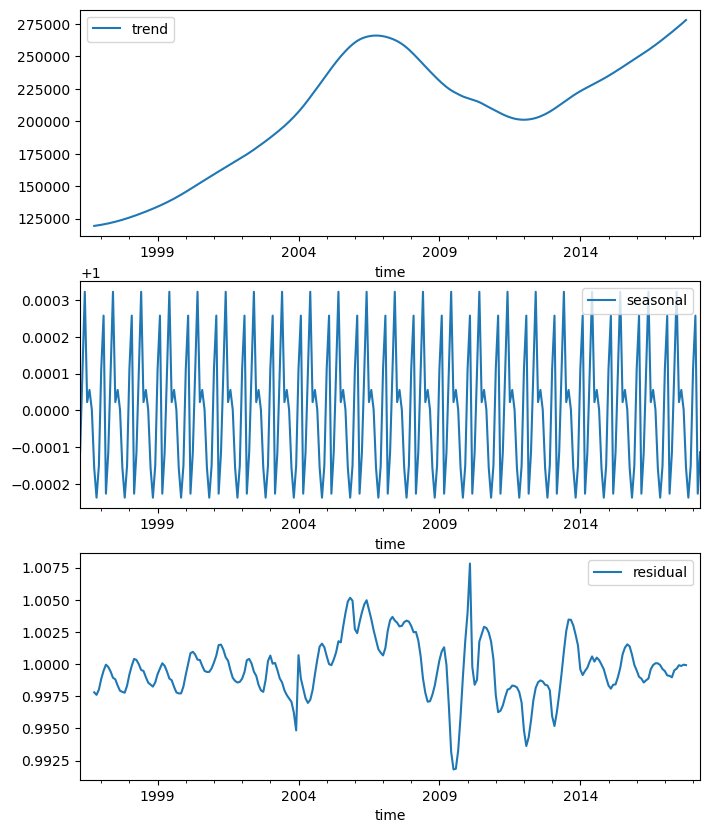

In [122]:
fig, ax = plt.subplots(3,1, figsize = (8,10))
result_us.trend.plot(ax = ax[0], label = 'trend')
ax[0].legend()
result_us.seasonal.plot(ax = ax[1], label = 'seasonal')
ax[1].legend()
result_us.resid.plot(ax = ax[2], label = 'residual')
ax[2].legend();

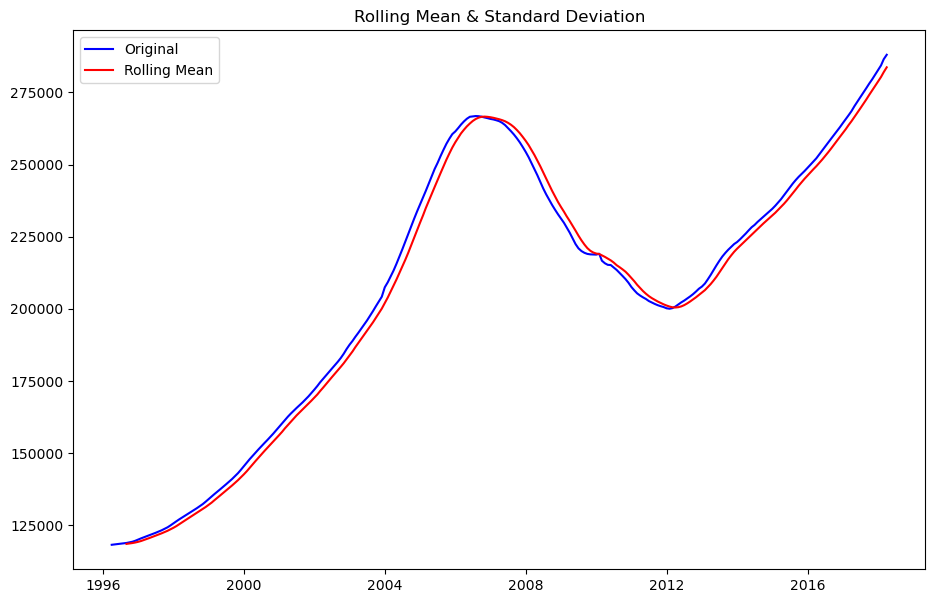

In [192]:
roll_mean = usa_mean.rolling(window=6).mean()
fig = plt.figure(figsize=(11,7))
plt.plot(usa_mean, color='blue',label='Original')
plt.plot(roll_mean, color='red', label='Rolling Mean')
plt.legend(loc='best')
plt.title('Rolling Mean & Standard Deviation')
plt.show(block=False)

In [193]:
data_minus_roll_mean = usa_mean - roll_mean
data_minus_roll_mean.head(15)

,value
time,
1996-04-01,NaN
1996-05-01,NaN
1996-06-01,NaN
1996-07-01,NaN
1996-08-01,NaN
1996-09-01,324.788074
1996-10-01,380.880347
1996-11-01,451.327585
1996-12-01,599.783202


In [194]:
data_minus_roll_mean.dropna(inplace=True)

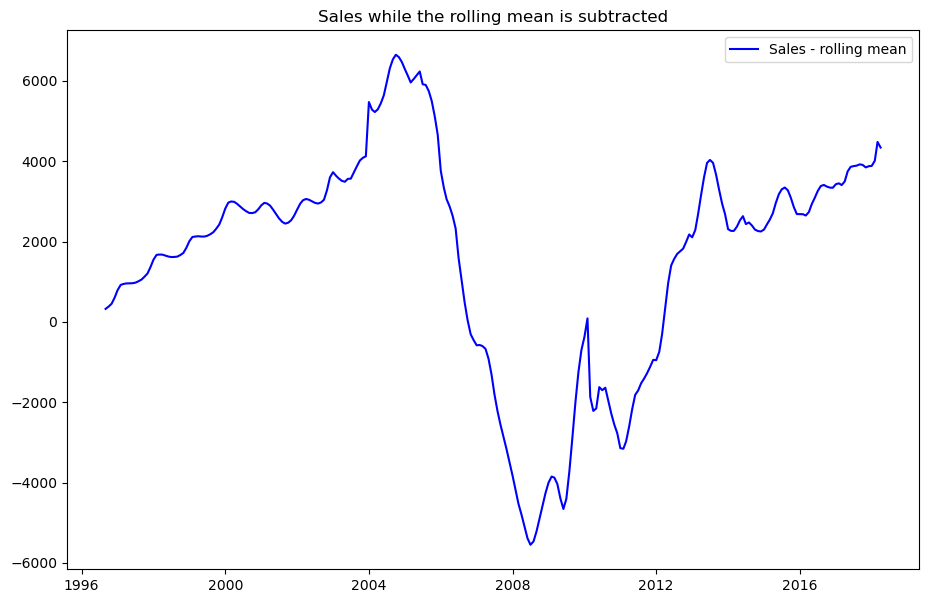

In [195]:
fig = plt.figure(figsize=(11,7))
plt.plot(data_minus_roll_mean, color='blue',label='Sales - rolling mean')
plt.legend(loc='best')
plt.title('Sales while the rolling mean is subtracted')
plt.show(block=False)

Exponentially Weighted Moving Average
[here](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.ewm.html).

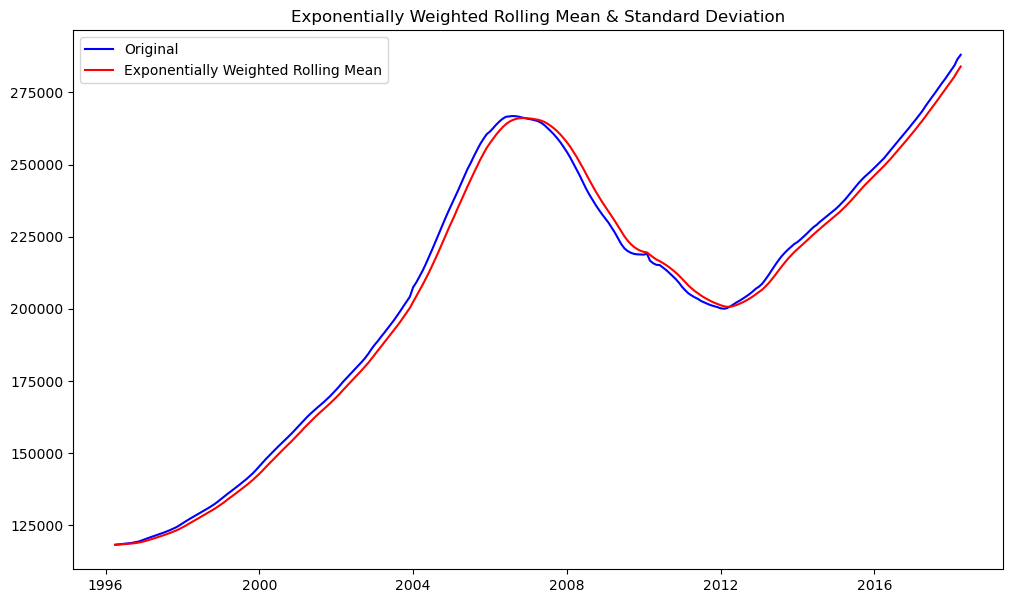

In [203]:
# Use Pandas ewm() to calculate Exponential Weighted Moving Average
exp_roll_mean = usa_mean.ewm(halflife=2).mean()

# Plot the original data with exp weighted average
fig = plt.figure(figsize=(12,7))
orig = plt.plot(usa_mean, color='blue',label='Original')
mean = plt.plot(exp_roll_mean, color='red', label='Exponentially Weighted Rolling Mean')
plt.legend(loc='best')
plt.title('Exponentially Weighted Rolling Mean & Standard Deviation')
plt.show(block=False)

In [204]:
# Subtract the moving average from the original data
data_minus_exp_roll_mean = usa_mean - exp_roll_mean
data_minus_exp_roll_mean.head(15)

,value
time,
1996-04-01,0.000000
1996-05-01,49.672936
1996-06-01,91.910726
1996-07-01,126.500789
1996-08-01,163.427375
1996-09-01,206.698843
1996-10-01,271.273384
1996-11-01,341.112366
1996-12-01,472.209581


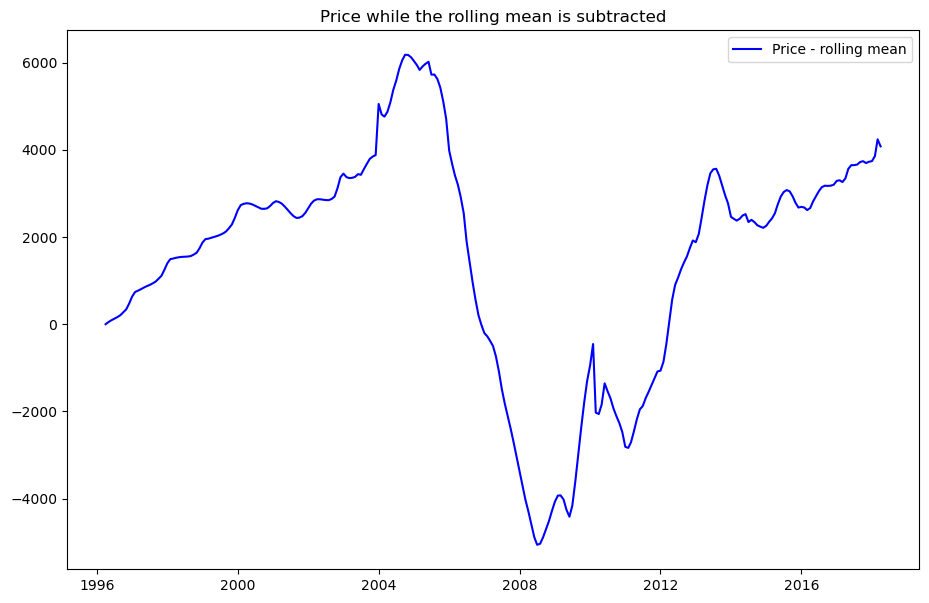

In [207]:
fig = plt.figure(figsize=(11,7))
plt.plot(data_minus_exp_roll_mean, color='blue',label='Price - rolling mean')
plt.legend(loc='best')
plt.title('Price while the rolling mean is subtracted')
plt.show(block=False)

In [209]:
data_diff = usa_mean.diff(periods=1)
data_diff.head(10)

,value
time,
1996-04-01,NaN
1996-05-01,119.921076
1996-06-01,118.379129
1996-07-01,115.646010
1996-08-01,127.185034
1996-09-01,147.274189
1996-10-01,192.991815
1996-11-01,224.831920
1996-12-01,339.732534


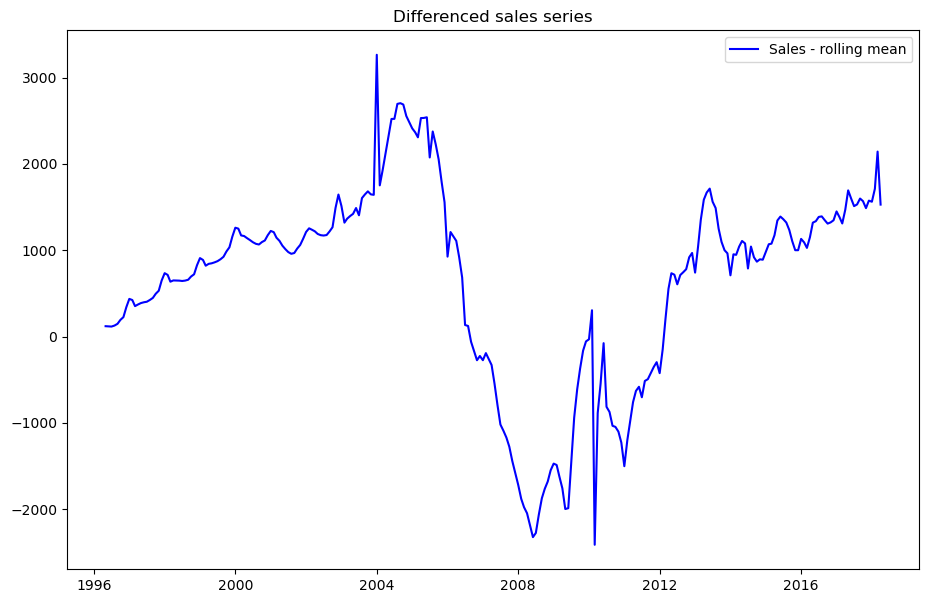

In [211]:
fig = plt.figure(figsize=(11,7))
plt.plot(data_diff, color='blue',label='Sales - rolling mean')
plt.legend(loc='best')
plt.title('Differenced sales series')
plt.show(block=False)

data.plot(figsize=(18,6), color='blue', linewidth=1, fontsize=14)

In [212]:
acf(usa_mean, nlags = 5, fft = True)

array([1.        , 0.98767054, 0.97483929, 0.96160063, 0.94790879,
       0.93375436])

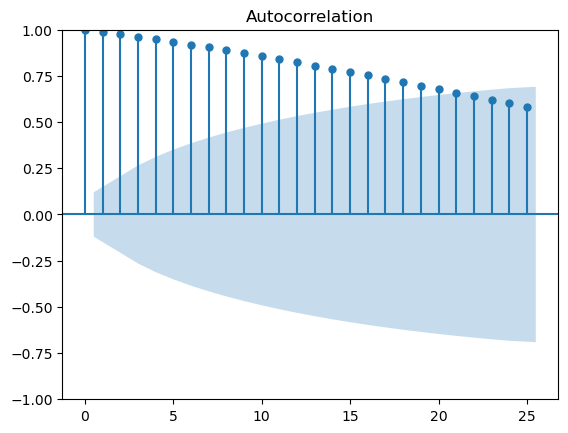

In [213]:
plot_acf(usa_mean)
plt.show()

In [214]:
pacf(usa_mean, nlags = 8)

array([ 1.        ,  0.99141172, -0.03769429, -0.03174168, -0.0343937 ,
       -0.03478834, -0.03362988, -0.03317377, -0.03143224])

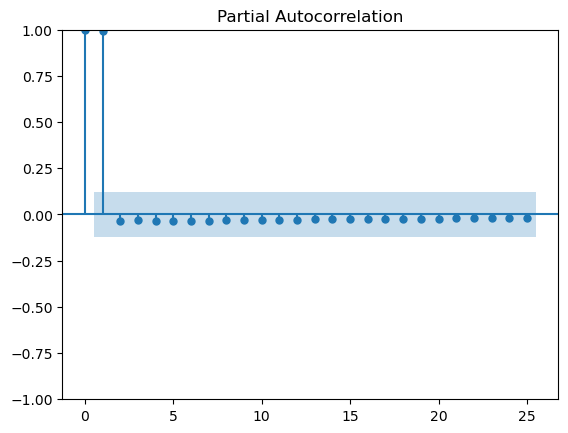

In [216]:
plot_pacf(usa_mean)
plt.show();

In [223]:
result = seasonal_decompose(usa_mean, period = 50)

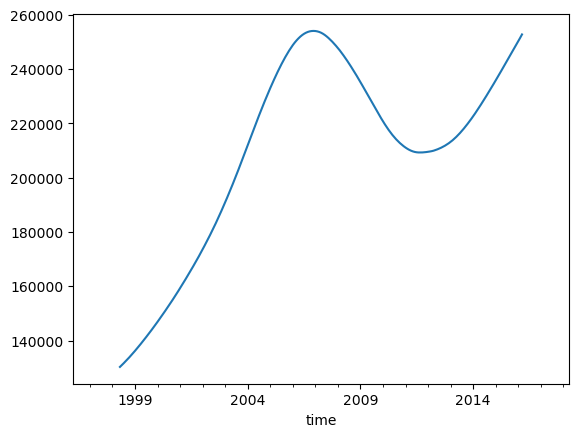

In [224]:
result.trend.plot()
plt.show()

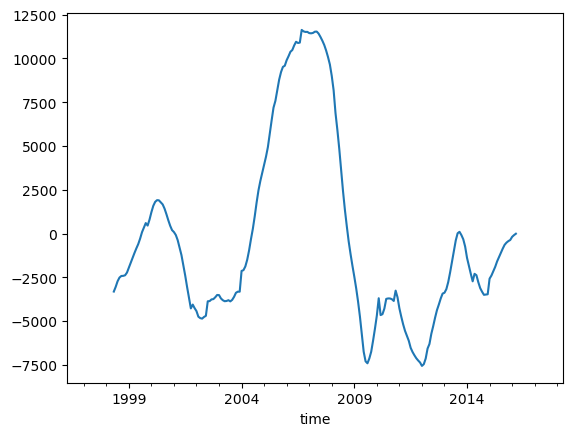

In [225]:
result.resid.plot()
plt.show()

In [226]:
adfuller(usa_mean)

(-1.8851445183777926,
 0.3390815439412539,
 2,
 262,
 {'1%': -3.455558114028747,
  '5%': -2.872635586277424,
  '10%': -2.572682677000175},
 3505.613476823798)

<Axes: xlabel='time'>

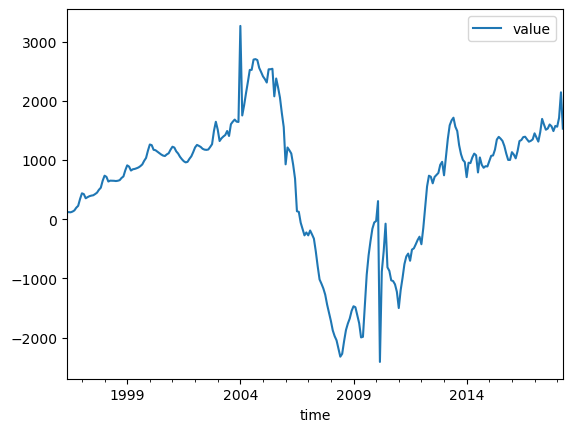

In [227]:
usa_mean_diff = usa_mean.diff().dropna()
usa_mean_diff.plot()

Slide Type
Slide
Down-sampling

- '1H': every 1 hour samples
- '2H': every 2 hours, etc
- 'T': minute frequency
- 'S' : second frequency
- 'D': daily
- 'W': weekly
- 'M': monthly

For more frequencies:

https://pandas.pydata.org/pandas-docs/stable/user_guide/timeseries.html#offset-aliases

NOTES

ROI by total time length
ROI each year
compare ROI by city, by zip within city
compare ROI by county
% change in price
risk factors




<Axes: xlabel='time'>

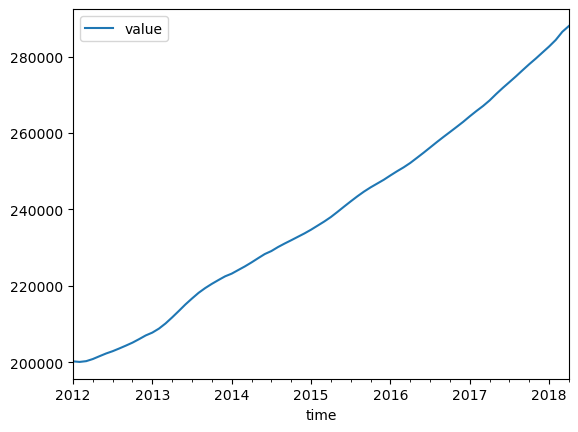

In [261]:
usa_mean.loc['2012':'2018'].plot()

In [231]:
adfuller(usa_mean_diff)

(-2.548781596834006,
 0.10405172262326762,
 13,
 250,
 {'1%': -3.456780859712, '5%': -2.8731715065600003, '10%': -2.572968544},
 3492.8977580070396)

In [232]:
result_usa = seasonal_decompose(usa_mean_diff, model='additive') 

In [233]:
%%capture usa_decomposition_plot
fig, ax = plt.subplots(3,1, figsize = (6,6))
result_usa.trend.plot(ax = ax[0], label = 'trend')
ax[0].legend()
result_usa.seasonal.plot(ax = ax[1], label = 'seasonal')
ax[1].legend()
result_usa.resid.plot(ax = ax[2], label = 'residual')
ax[2].legend()

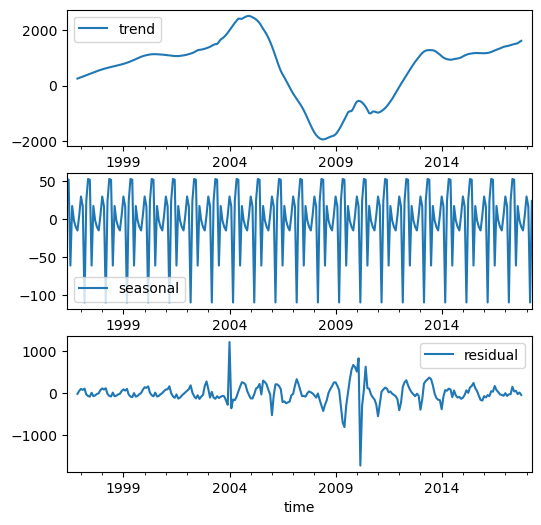

In [234]:
usa_decomposition_plot()

<Axes: xlabel='time'>

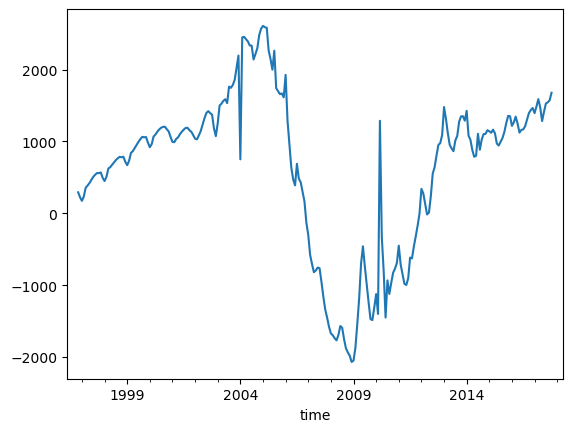

In [237]:
reconstruct = result_usa.trend-result_usa.seasonal-result_usa.resid

reconstruct.plot()

<Axes: xlabel='time'>

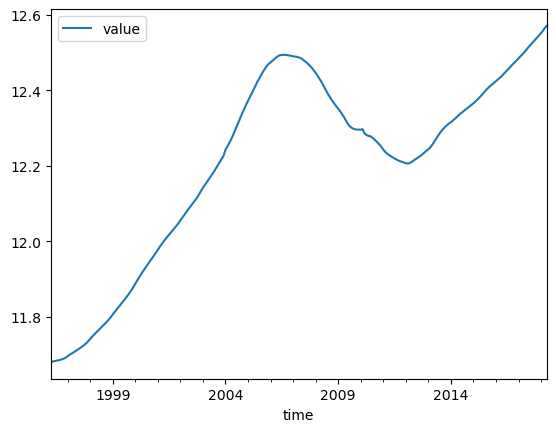

In [287]:
logged_data = np.log(usa_mean)
logged_data.plot()

<Axes: xlabel='time'>

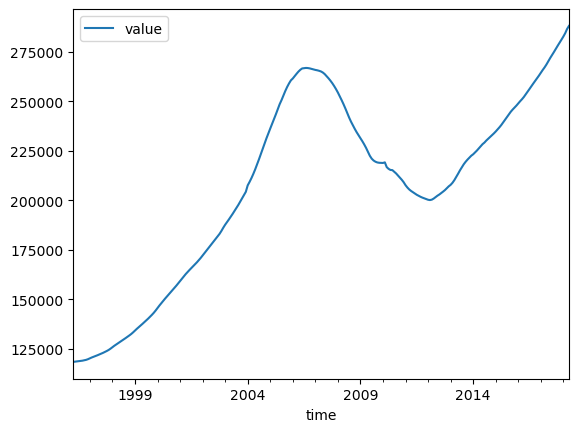

In [310]:
usa_mean.plot()

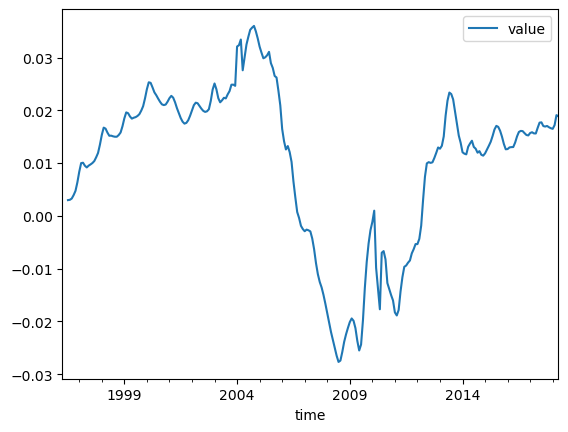

In [243]:
logged_data.diff(3).plot()
plt.show()

In [308]:
usa_rolling = usa_mean.rolling(window = 2).mean().dropna()

In [309]:
log_roll_data = usa_mean - usa_rolling 
log_roll_data.dropna(inplace = True)

adfuller(log_roll_data)

(-2.548781596834042,
 0.10405172262325951,
 13,
 250,
 {'1%': -3.456780859712, '5%': -2.8731715065600003, '10%': -2.572968544},
 3150.483050810425)

In [298]:
log_diff_data = logged_data.diff(3).dropna()
adfuller(log_diff_data)

(-2.250499666127554,
 0.1884298328853442,
 10,
 251,
 {'1%': -3.4566744514553016,
  '5%': -2.8731248767783426,
  '10%': -2.5729436702592023},
 -2528.2140818674793)

<Axes: xlabel='time'>

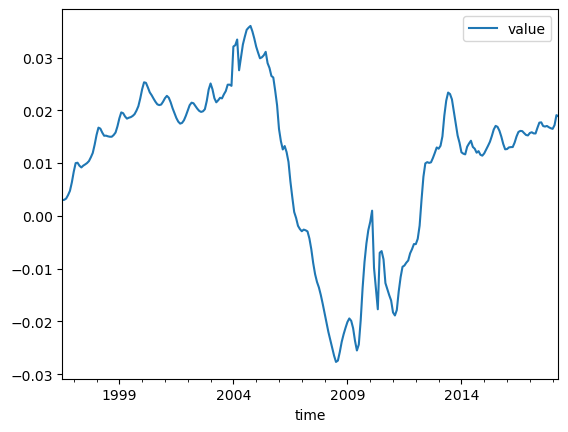

In [299]:
log_diff_data.plot()

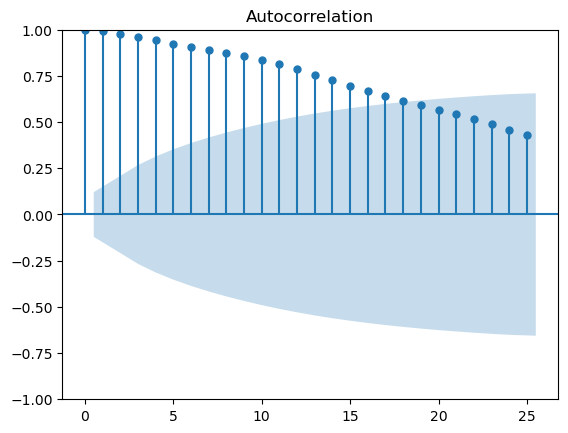

In [256]:
plot_acf(differenced_data)
plt.show()

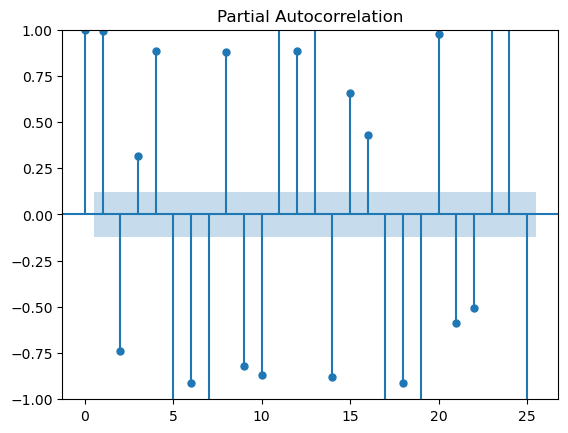

In [258]:
plot_pacf(differenced_data)
plt.show();

In [312]:
exp_roll_mean = np.log(usa_mean).ewm(halflife=4).mean()

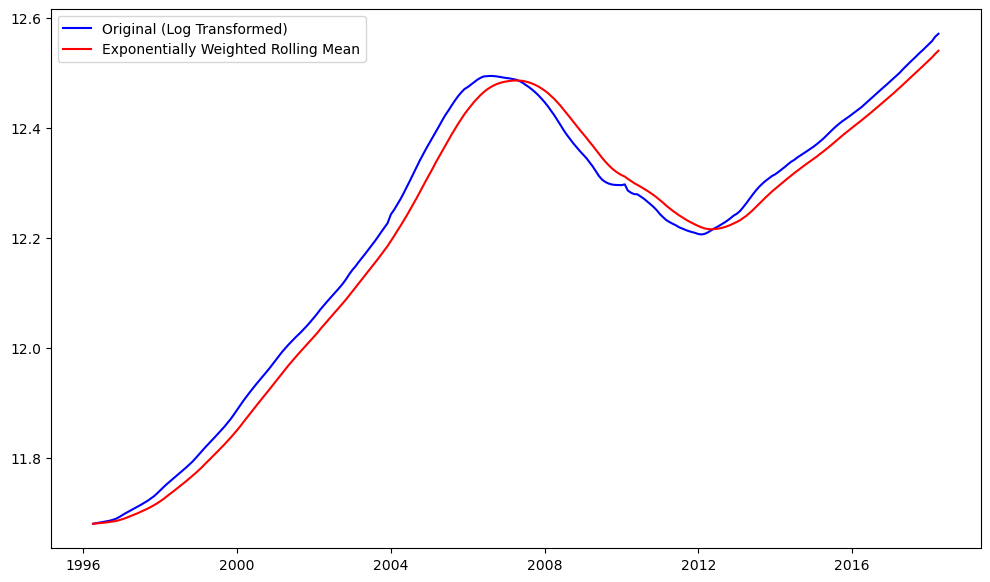

In [314]:
fig = plt.figure(figsize=(12,7))
plt.plot(np.log(usa_mean), color='blue',label='Original (Log Transformed)')
plt.plot(exp_roll_mean, color='red', label='Exponentially Weighted Rolling Mean')
plt.legend(loc='best')
plt.show(block=False)

## (Logged) - (Explonentially Weighted Mean) : np.log(usa_mean) - exp_roll_mean

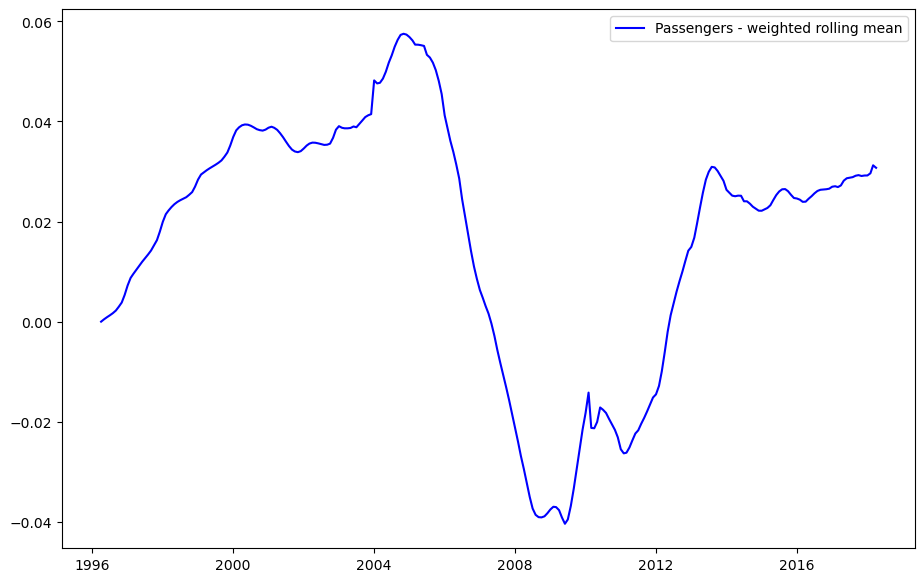

In [316]:
# Subtract the moving average from the original data and check head for Nans
data_minus_exp_roll_mean = np.log(usa_mean) - exp_roll_mean

# Plot the time series
fig = plt.figure(figsize=(11,7))
plt.plot(data_minus_exp_roll_mean, color='blue',label='Passengers - weighted rolling mean')
plt.legend(loc='best')
plt.show(block=False)

In [319]:

def stationarity_check(TS):
    
    # Import adfuller
    from statsmodels.tsa.stattools import adfuller
    
    # Calculate rolling statistics
    roll_mean = TS.rolling(window=8, center=False).mean()
    roll_std = TS.rolling(window=8, center=False).std()
    
    # Perform the Dickey Fuller Test
    dftest = adfuller(TS)
    
    # Plot rolling statistics:
    fig = plt.figure(figsize=(12,6))
    plt.plot(TS, color='blue',label='Original')
    plt.plot(roll_mean, color='red', label='Rolling Mean')
    plt.plot(roll_std, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    # Print Dickey-Fuller test results
    print('Results of Dickey-Fuller Test: \n')

    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', 
                                             '#Lags Used', 'Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)
    
    return None


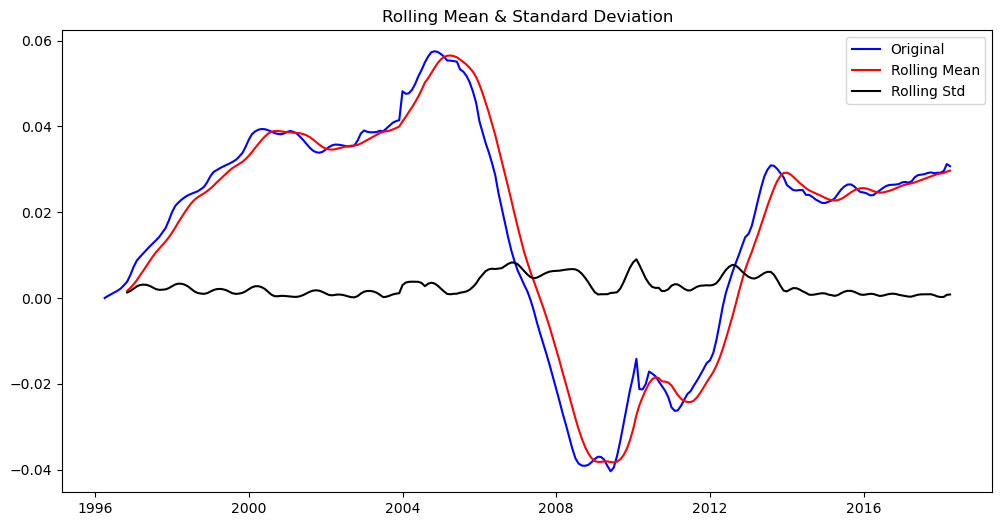

Results of Dickey-Fuller Test: 

Test Statistic                  -2.010571
p-value                          0.281958
#Lags Used                       4.000000
Number of Observations Used    260.000000
Critical Value (1%)             -3.455754
Critical Value (5%)             -2.872721
Critical Value (10%)            -2.572728
dtype: float64


In [320]:
stationarity_check(data_minus_exp_roll_mean)

In [325]:
data_diff = data_minus_exp_roll_mean.diff(periods=3)

# Drop the missing values
data_diff.dropna(inplace=True)

# Check out the first few rows
data_diff.head(15)

,value
time,
1996-07-01,0.001270
1996-08-01,0.001236
1996-09-01,0.001327
1996-10-01,0.001697
1996-11-01,0.002125
1996-12-01,0.003109
1997-01-01,0.004262
1997-02-01,0.004913
1997-03-01,0.004213


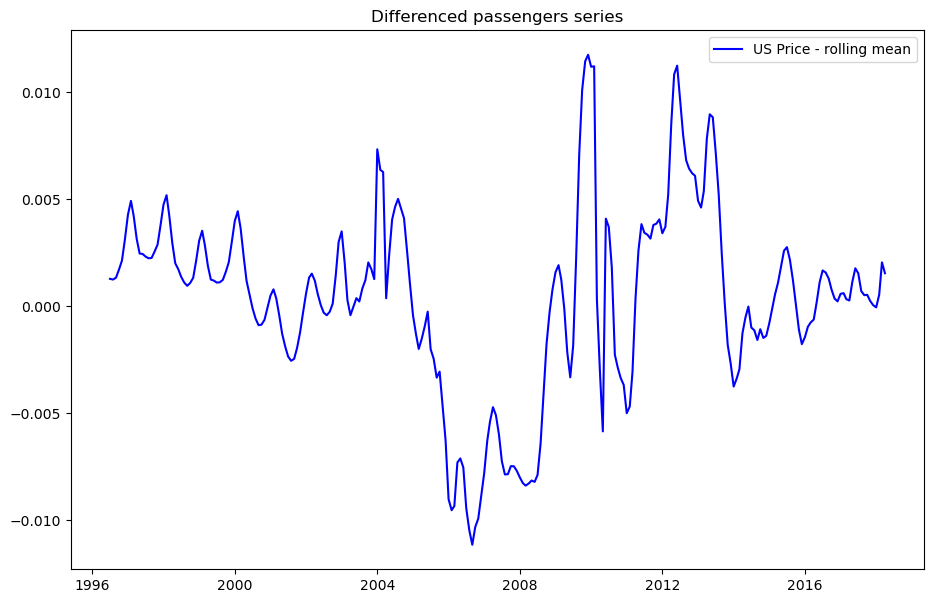

In [328]:
fig = plt.figure(figsize=(11,7))
plt.plot(data_diff, color='blue',label='US Price - rolling mean')
plt.legend(loc='best')
plt.title('Differenced passengers series')
plt.show(block=False)

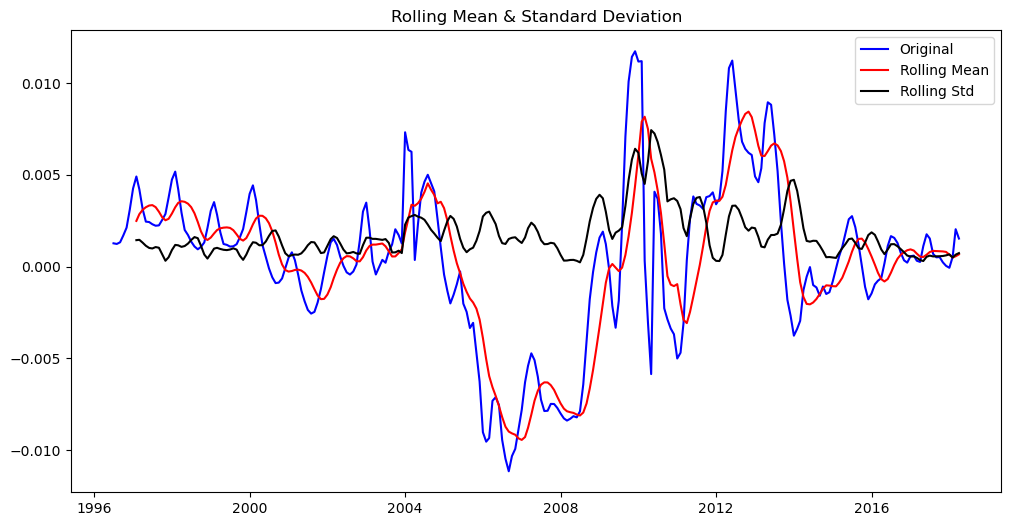

Results of Dickey-Fuller Test: 

Test Statistic                  -3.195600
p-value                          0.020241
#Lags Used                      11.000000
Number of Observations Used    250.000000
Critical Value (1%)             -3.456781
Critical Value (5%)             -2.873172
Critical Value (10%)            -2.572969
dtype: float64


In [327]:
stationarity_check(data_diff)


In [388]:
# Exponentially Weighted Mean
exp_roll_mean = np.log(usa_mean).ewm(halflife=2).mean()

# Logged - EWM
data_minus_exp_roll_mean = np.log(usa_mean) - exp_roll_mean

# Differencing of (Logged - EWM)
data_diff_4 = data_minus_exp_roll_mean.diff(periods=4)

# Drop the missing values
diff_log_exp_mean_4 = data_diff_4.dropna()


In [389]:
adfuller(diff_log_exp_mean)

(-3.2718101558760084,
 0.016186556632203038,
 13,
 247,
 {'1%': -3.457105309726321,
  '5%': -2.873313676101283,
  '10%': -2.5730443824681606},
 -2674.8794225856336)

In [392]:
# Exponentially Weighted Mean
exp_roll_mean = np.log(usa_mean).ewm(halflife=2).mean()

# Logged - EWM
data_minus_exp_roll_mean = np.log(usa_mean) - exp_roll_mean

# Differencing of (Logged - EWM)
data_diff_9 = data_minus_exp_roll_mean.diff(periods=9)

# Drop the missing values
diff_log_exp_mean_9 = data_diff_9.dropna()

In [405]:
adfuller(diff_log_exp_mean)

(-3.2718101558760084,
 0.016186556632203038,
 13,
 247,
 {'1%': -3.457105309726321,
  '5%': -2.873313676101283,
  '10%': -2.5730443824681606},
 -2674.8794225856336)

In [407]:
for i,k in range()
    print(i,k)

ValueError: too many values to unpack (expected 2)

In [464]:
def try_diffed_log_minus_ewm(TS):

    min_p = 1
    
    for i, k in itertools.product(range(1,8), range(1,13)):
        exp_roll_mean = np.log(TS).ewm(halflife = i).mean()

        # Logged - EWM
        data_minus_exp_roll_mean = np.log(TS) - exp_roll_mean

        # Differencing of (Logged - EWM)
        data_diff = data_minus_exp_roll_mean.diff(periods = k)

        # Drop the missing values
        diff_log_exp_mean = data_diff.dropna()
        
        p = adfuller(diff_log_exp_mean)[1]
        
        if p < min_p:
            min_p = p
        
        print(min_p)
        print(f'Half Life: {i} ; Diff Period : {k} \nP Value {p}\n')


In [465]:
try_diffed_log_minus_ewm(usa_mean)

0.012111360126266728
Half Life: 1 ; Diff Period : 1 
P Value 0.012111360126266728

0.012111360126266728
Half Life: 1 ; Diff Period : 2 
P Value 0.06833287164729318

0.012111360126266728
Half Life: 1 ; Diff Period : 3 
P Value 0.022826404429015925

0.012111360126266728
Half Life: 1 ; Diff Period : 4 
P Value 0.021392422564830902

0.012111360126266728
Half Life: 1 ; Diff Period : 5 
P Value 0.049473842957513815

0.012111360126266728
Half Life: 1 ; Diff Period : 6 
P Value 0.043386941433410424

0.012111360126266728
Half Life: 1 ; Diff Period : 7 
P Value 0.08490732461996209

0.012111360126266728
Half Life: 1 ; Diff Period : 8 
P Value 0.17767848189120788

0.012111360126266728
Half Life: 1 ; Diff Period : 9 
P Value 0.018587222993798454

0.012111360126266728
Half Life: 1 ; Diff Period : 10 
P Value 0.029202694169157575

0.012111360126266728
Half Life: 1 ; Diff Period : 11 
P Value 0.08257899253272988

0.012111360126266728
Half Life: 1 ; Diff Period : 12 
P Value 0.06127971345188886

0.0121

In [466]:
def best_diffed_log_minus_ewm(TS):

    min_p = 1
    
    for i, k in itertools.product(range(1,8), range(1,13)):
        exp_roll_mean = np.log(TS).ewm(halflife = i).mean()

        # Logged - EWM
        data_minus_exp_roll_mean = np.log(TS) - exp_roll_mean

        # Differencing of (Logged - EWM)
        data_diff = data_minus_exp_roll_mean.diff(periods = k)

        # Drop the missing values
        diff_log_exp_mean = data_diff.dropna()
        
        p = adfuller(diff_log_exp_mean)[1]
        
        if p < min_p:
            min_p = p
        
            print(min_p)
            print(f'Half Life: {i} ; Diff Period : {k} \nP Value {p}\n')

In [467]:
best_diffed_log_minus_ewm(usa_mean)

0.012111360126266728
Half Life: 1 ; Diff Period : 1 
P Value 0.012111360126266728

0.009994418783171997
Half Life: 2 ; Diff Period : 9 
P Value 0.009994418783171997

0.0008344262073295845
Half Life: 3 ; Diff Period : 1 
P Value 0.0008344262073295845



In [468]:
def try_diff1_log_minus_ewm(TS):

    min_p = 1
    
    for i in range(1,8):
        exp_roll_mean = np.log(TS).ewm(halflife = i).mean()

        # Logged - EWM
        data_minus_exp_roll_mean = np.log(TS) - exp_roll_mean

        # Differencing of (Logged - EWM)
        data_diff = data_minus_exp_roll_mean.diff

        # Drop the missing values
        diff_log_exp_mean = data_diff.dropna()
        
        p = adfuller(diff_log_exp_mean)[1]
        
        if p < min_p:
            min_p = p
        
        print(min_p)
        print(f'Half Life: {i} ; Diff \nP Value {p}\n')

In [534]:
exp_roll_mean = np.log(usa_mean).ewm(halflife = 3).mean()

        # Logged - EWM
data_minus_exp_roll_mean = np.log(usa_mean) - exp_roll_mean

logewm_log_min_mean_diff = data_minus_exp_roll_mean.diff().dropna()

In [535]:
logewm_log_min_mean_diff

,value
time,
1996-05-01,0.000448
1996-06-01,0.000402
1996-07-01,0.000351
1996-08-01,0.000387
1996-09-01,0.000461
...,...
2017-12-01,0.000054
2018-01-01,-0.000018
2018-02-01,0.000380


In [536]:
adfuller(logewm_log_min_mean_diff)

(-4.138971956074198,
 0.0008344262073295845,
 3,
 260,
 {'1%': -3.4557539868570775,
  '5%': -2.8727214497041422,
  '10%': -2.572728476331361},
 -2691.234629393834)

## Modeling

In [545]:
logewm_log_min_mean_diff

,value
time,
1996-05-01,0.000448
1996-06-01,0.000402
1996-07-01,0.000351
1996-08-01,0.000387
1996-09-01,0.000461
...,...
2017-12-01,0.000054
2018-01-01,-0.000018
2018-02-01,0.000380


In [547]:
(2018 - 1995)*.2

4.6000000000000005

In [550]:
split = '2014'

train_arma11 = logewm_log_min_mean_diff[: split]
test_arma11 = logewm_log_min_mean_diff[split:]
print(train_arma11.shape, test_arma11.shape)

(224, 1) (52, 1)


In [552]:
model = ARIMA(train_arma11, order = (1, 0, 1))
results = model.fit();

/Users/eitan/anaconda3/envs/Number41/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/eitan/anaconda3/envs/Number41/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/eitan/anaconda3/envs/Number41/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/eitan/anaconda3/envs/Number41/lib/python3.11/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [554]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  value   No. Observations:                  224
Model:                 ARIMA(1, 0, 1)   Log Likelihood                1214.333
Date:                Wed, 12 Jul 2023   AIC                          -2420.666
Time:                        16:26:48   BIC                          -2407.020
Sample:                    05-01-1996   HQIC                         -2415.158
                         - 12-01-2014                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       6.994e-05      0.000      0.196      0.845      -0.001       0.001
ar.L1          0.8340      0.057     14.540      0.000       0.722       0.946
ma.L1         -0.3254      0.055     -5.943      0.000      -0.433      -0.218
sigma2      1.131e-06   4.47e-08     25.308      0.000    1.04e-06    1.22e-06
===================================================================================
Ljung-Box (L1) (Q):                   0.02   Jarque-Bera (JB):             10782.47
Prob(Q):                              0.88   Prob(JB):                         0.00
Heteroskedasticity (H):              20.42   Skew:                            -2.54
Prob(H) (two-sided):                  0.00   Kurtosis:                        36.61
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [555]:
dict(zip(results.param_names, results.params))

{'const': 6.99429267718285e-05,
 'ar.L1': 0.8339973298756918,
 'ma.L1': -0.3253772768791122,
 'sigma2': 1.1312176406831106e-06}

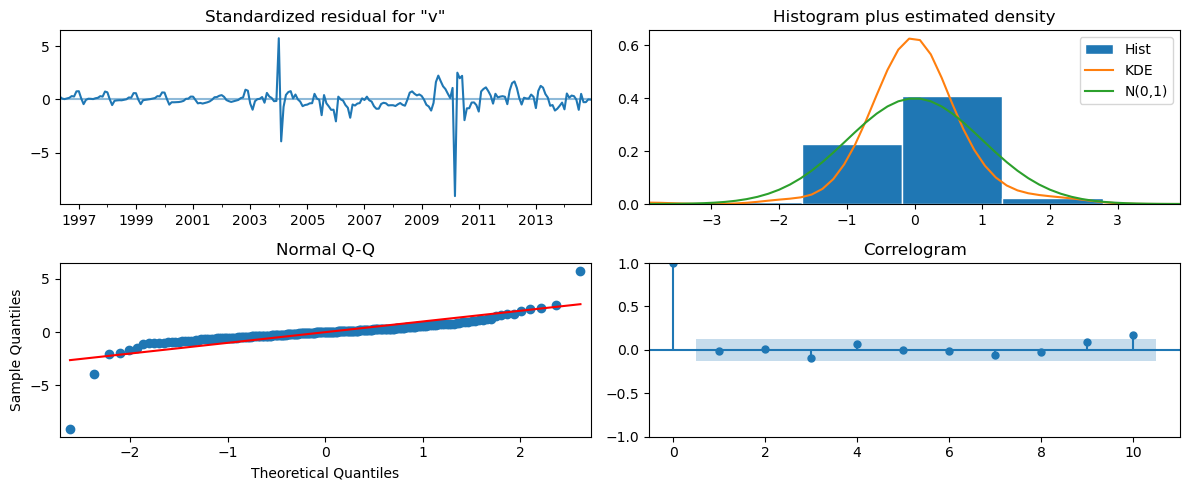

In [560]:
results.plot_diagnostics(figsize = (12,5))
plt.tight_layout()
plt.show()

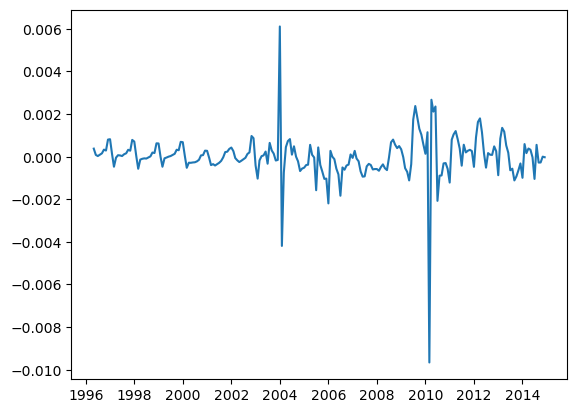

In [558]:
residuals_arma11 = results.resid
plt.plot(residuals_arma11);

In [561]:
modl = pm.auto_arima(train_arma11, start_p=1, start_q=4,
                     max_p=4, max_q=4, d= 0, trace=True, stepwise=True, suppress_warnings=True,
                     error_action='ignore')

Performing stepwise search to minimize aic
 ARIMA(1,0,4)(0,0,0)[0] intercept   : AIC=-2418.017, Time=0.18 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=-2285.891, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=-2410.774, Time=0.06 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=-2353.645, Time=0.06 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=-2287.372, Time=0.01 sec
 ARIMA(0,0,4)(0,0,0)[0] intercept   : AIC=-2403.914, Time=0.14 sec
 ARIMA(1,0,3)(0,0,0)[0] intercept   : AIC=-2420.095, Time=0.12 sec
 ARIMA(0,0,3)(0,0,0)[0] intercept   : AIC=-2397.652, Time=0.09 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=-2418.449, Time=0.07 sec
 ARIMA(2,0,3)(0,0,0)[0] intercept   : AIC=-2418.653, Time=0.06 sec
 ARIMA(0,0,2)(0,0,0)[0] intercept   : AIC=-2393.174, Time=0.10 sec
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=-2416.912, Time=0.12 sec
 ARIMA(2,0,4)(0,0,0)[0] intercept   : AIC=-2415.339, Time=0.14 sec
 ARIMA(1,0,3)(0,0,0)[0]             : AIC=-2422.044, Time=0.03 sec
 ARIMA(0,0,3)(0,0,0

In [562]:
model_2 = ARIMA(train_arma11, order = (0, 0, 0))
results_2 = model_2.fit();

/Users/eitan/anaconda3/envs/Number41/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/eitan/anaconda3/envs/Number41/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/eitan/anaconda3/envs/Number41/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


In [563]:
results_2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  value   No. Observations:                  224
Model:                          ARIMA   Log Likelihood                1144.944
Date:                Wed, 12 Jul 2023   AIC                          -2285.887
Time:                        16:36:34   BIC                          -2279.064
Sample:                    05-01-1996   HQIC                         -2283.133
                         - 12-01-2014                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       6.541e-05   9.74e-05      0.671      0.502      -0.000       0.000
sigma2       2.12e-06    1.2e-07     17.605      0.000    1.88e-06    2.36e-06
===================================================================================
Ljung-Box (L1) (Q):                  98.45   Jarque-Bera (JB):               117.82
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               8.52   Skew:                            -0.19
Prob(H) (two-sided):                  0.00   Kurtosis:                         6.53
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

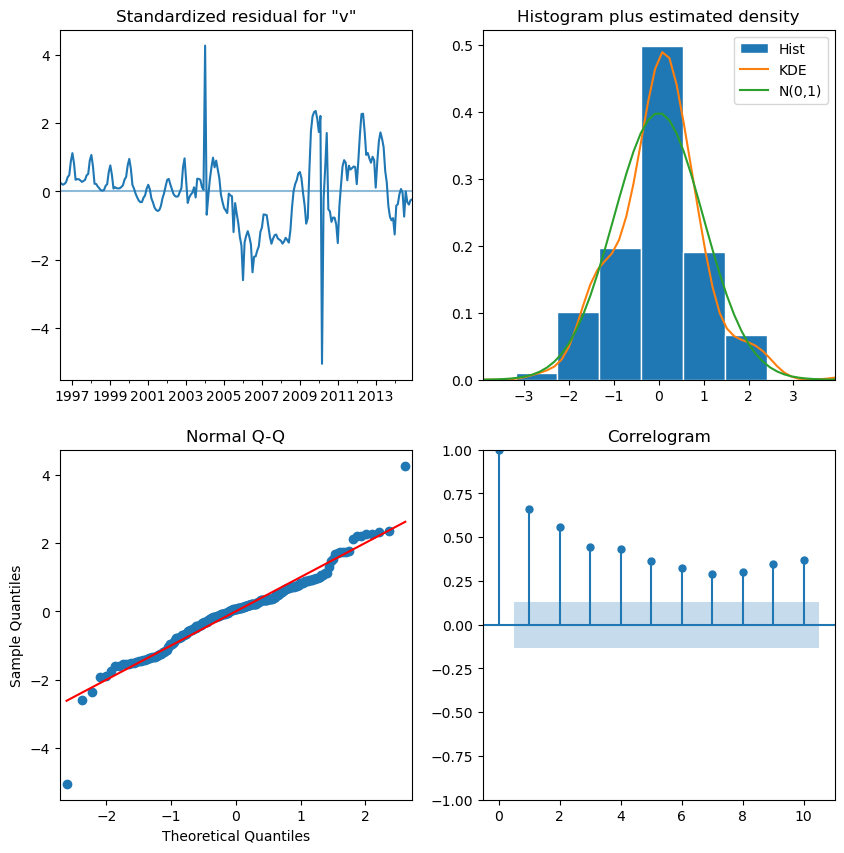

In [564]:
results_2.plot_diagnostics(figsize = (10,10))
plt.show()

In [543]:
model = ARIMA(train_arma11, order = (1, 0, 1))
results = model.fit();

/Users/eitan/anaconda3/envs/Number41/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/eitan/anaconda3/envs/Number41/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/eitan/anaconda3/envs/Number41/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


In [539]:
chicago_price = chicago['Price']

In [540]:
exp_roll_mean_chi = np.log(chicago_price).ewm(halflife = 3).mean()

        # Logged - EWM
data_minus_exp_roll_mean_chi = np.log(chicago_price) - exp_roll_mean

logewm_log_min_mean_diff_chi = data_minus_exp_roll_mean.diff().dropna()

In [541]:
adfuller(logewm_log_min_mean_diff_chi)

(-4.138971956074198,
 0.0008344262073295845,
 3,
 260,
 {'1%': -3.4557539868570775,
  '5%': -2.8727214497041422,
  '10%': -2.572728476331361},
 -2691.234629393834)

In [479]:
exp_roll_mean = np.log(usa_mean).ewm(halflife = 4).mean()

        # Logged - EWM
data_minus_exp_roll_mean = np.log(usa_mean) - exp_roll_mean

<Axes: xlabel='time'>

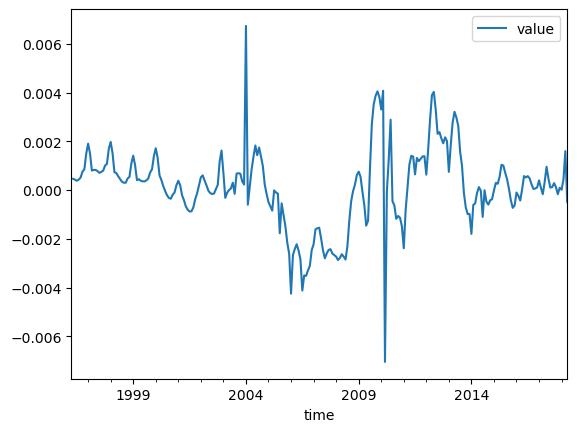

In [488]:
data_minus_exp_roll_mean.diff().plot()

In [490]:
adfuller(data_minus_exp_roll_mean.diff().dropna())

(-3.5627418091877012,
 0.006514600549512873,
 3,
 260,
 {'1%': -3.4557539868570775,
  '5%': -2.8727214497041422,
  '10%': -2.572728476331361},
 -2662.990153860212)

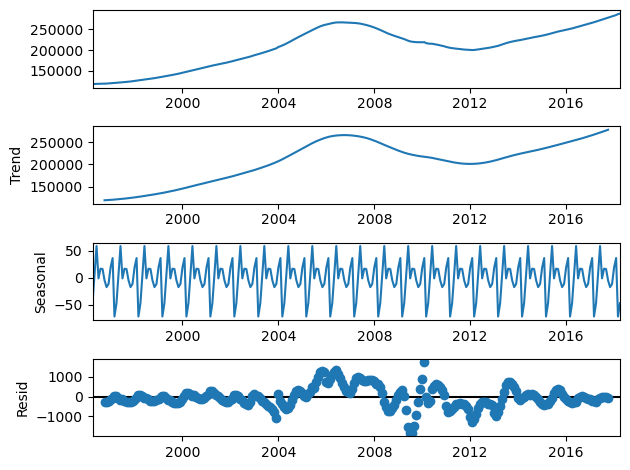

In [505]:
#fig, ax = plt.subplots(figsize = (12,6))
result = seasonal_decompose(usa_mean, model='additive')
result.plot()
plt.show()

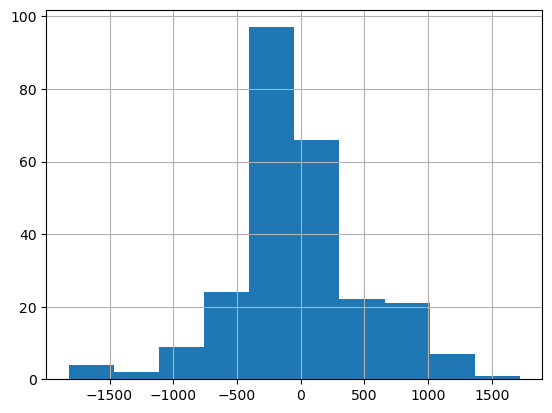

In [515]:
result = seasonal_decompose(usa_mean, model='additive')

result.resid.hist();

In [520]:
resid = result.resid.dropna()

In [522]:
normalized_resid=(resid-resid.mean())/resid.std()

<Axes: >

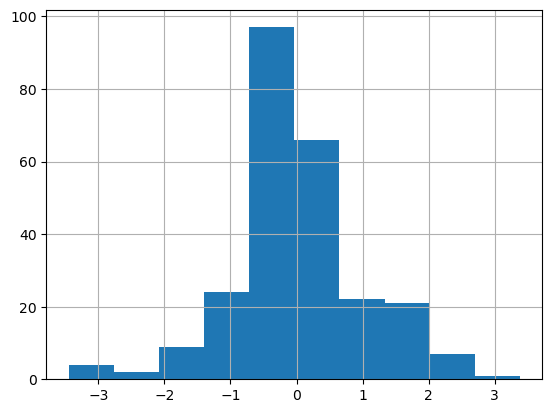

In [523]:
normalized_resid.hist()

In [526]:
df_chi_price = chicago['Price']

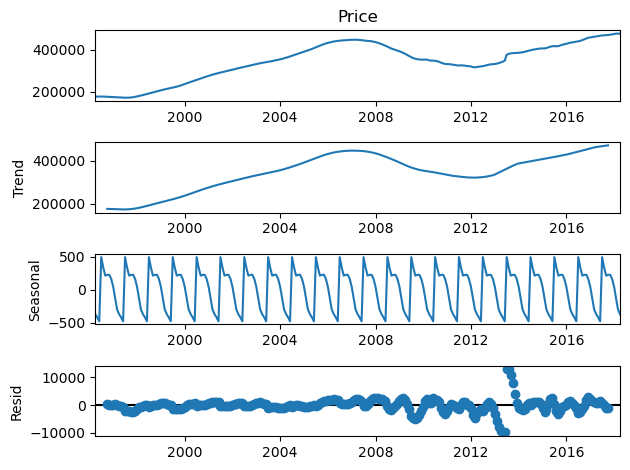

In [529]:
#fig, ax = plt.subplots(figsize = (12,6))
result_chi = seasonal_decompose(df_chi_price, model='additive')
result_chi.plot()
plt.show()

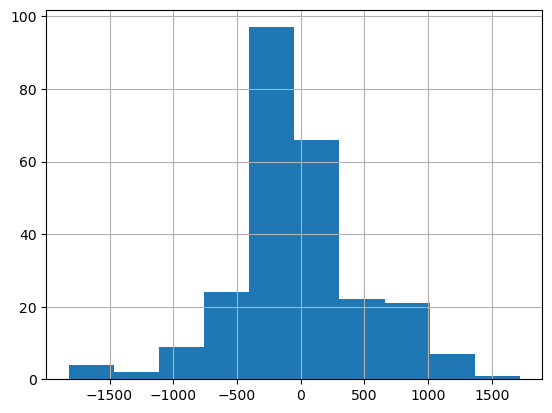

In [527]:
result_chi = seasonal_decompose(df_chi_price, model='additive')

result.resid.hist();

In [ ]:
model = ARIMA(train_arma11, order = (1, 0, 1))


In [482]:
log_roll_mean = np.log(usa_mean).rolling(window=7).mean()

In [483]:
data_minus_roll_mean = np.log(usa_mean) - log_roll_mean

<Axes: xlabel='time'>

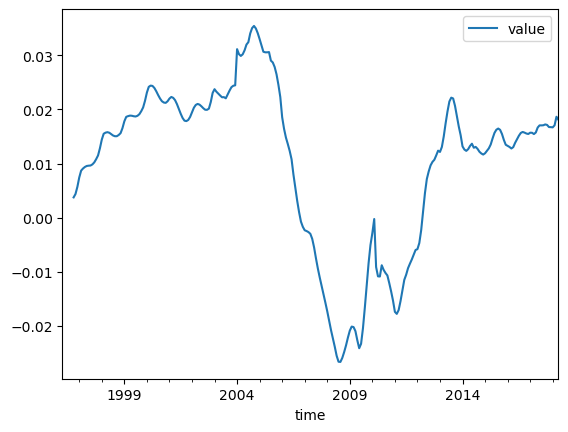

In [484]:
data_minus_roll_mean.plot()

In [486]:
data_minus_roll_mean

,value
time,
1996-04-01,NaN
1996-05-01,NaN
1996-06-01,NaN
1996-07-01,NaN
1996-08-01,NaN
...,...
2017-12-01,0.016732
2018-01-01,0.016690
2018-02-01,0.017074


In [487]:
adfuller(data_minus_roll_mean.dropna())

(-2.4276092585814757,
 0.1340950295751921,
 10,
 248,
 {'1%': -3.4569962781990573,
  '5%': -2.8732659015936024,
  '10%': -2.573018897632674},
 -2600.6817701290115)

<Axes: xlabel='time'>

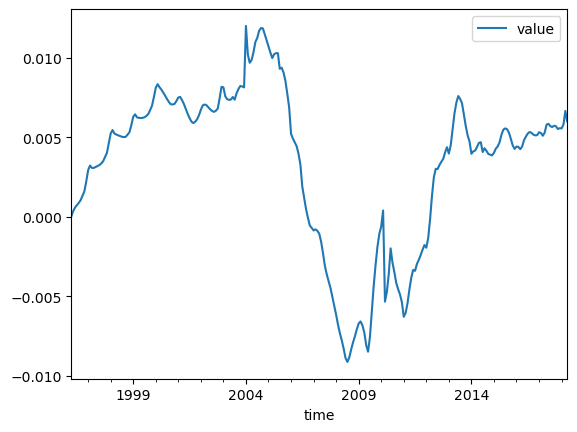

In [478]:
data_minus_exp_roll_mean.plot()

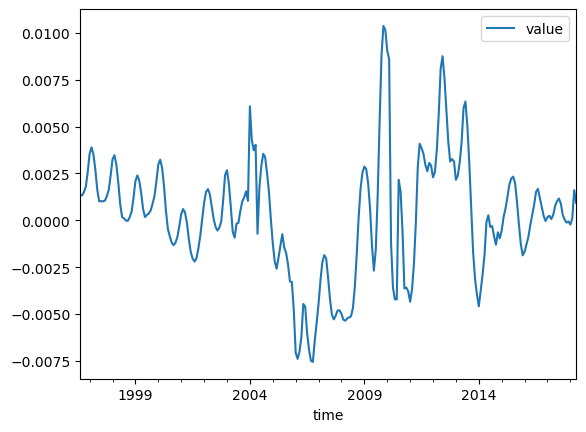

In [395]:
diff_log_exp_mean.plot();

In [ ]:
usa_mean['20']

In [267]:
n_test = '2013'
train_arma11 = usa_mean.loc[:,n_test]
test_arma11 = usa_mean.loc[n_test,:]

/var/folders/d9/xswmylg9377__r4x6b40670h0000gn/T/ipykernel_1343/2488830317.py:2: FutureWarning: Indexing a DataFrame with a datetimelike index using a single string to slice the rows, like `frame[string]`, is deprecated and will be removed in a future version. Use `frame.loc[string]` instead.
  train_arma11 = usa_mean.loc[:,n_test]


In [268]:
model = ARIMA(train_arma11, order = (1, 1, 1))
results = model.fit()

/Users/eitan/anaconda3/envs/Number41/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/eitan/anaconda3/envs/Number41/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/eitan/anaconda3/envs/Number41/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/eitan/anaconda3/envs/Number41/lib/python3.11/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [269]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  value   No. Observations:                   12
Model:                 ARIMA(1, 1, 1)   Log Likelihood                 -76.404
Date:                Wed, 12 Jul 2023   AIC                            158.808
Time:                        12:33:49   BIC                            160.002
Sample:                    01-01-2013   HQIC                           158.056
                         - 12-01-2013                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9785      0.016     61.295      0.000       0.947       1.010
ma.L1         -0.9204      0.033    -27.480      0.000      -0.986      -0.855
sigma2      5.622e+04   5.95e-09   9.45e+12      0.000    5.62e+04    5.62e+04
===================================================================================
Ljung-Box (L1) (Q):                   4.95   Jarque-Bera (JB):                 0.79
Prob(Q):                              0.03   Prob(JB):                         0.67
Heteroskedasticity (H):               0.52   Skew:                            -0.11
Prob(H) (two-sided):                  0.55   Kurtosis:                         1.71
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 7.57e+28. Standard errors may be unstable.
"""

In [275]:
n_test = '2013'
train_arma11_diff = log_diff_data.loc[:,n_test]
test_arma11_diff = log_diff_data.loc[n_test,:];

/var/folders/d9/xswmylg9377__r4x6b40670h0000gn/T/ipykernel_1343/288722601.py:2: FutureWarning: Indexing a DataFrame with a datetimelike index using a single string to slice the rows, like `frame[string]`, is deprecated and will be removed in a future version. Use `frame.loc[string]` instead.
  train_arma11_diff = log_diff_data.loc[:,n_test]


In [277]:
model = ARIMA(train_arma11, order = (1, 1, 1))
results = model.fit();

/Users/eitan/anaconda3/envs/Number41/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/eitan/anaconda3/envs/Number41/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/eitan/anaconda3/envs/Number41/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/eitan/anaconda3/envs/Number41/lib/python3.11/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [311]:
modl = pm.auto_arima(train_arma11, start_p=1, start_q=1,
                     max_p=5, max_q=5, d= 1, trace=True, stepwise=True, suppress_warnings=True,
                     error_action='ignore')

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-107.990, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-100.575, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-110.377, Time=0.01 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-106.854, Time=0.01 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-102.548, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-112.865, Time=0.03 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=-111.608, Time=0.02 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-110.711, Time=0.04 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=-109.698, Time=0.04 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=-114.856, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-112.420, Time=0.02 sec
 ARIMA(3,1,0)(0,0,0)[0]             : AIC=-115.542, Time=0.03 sec
 ARIMA(4,1,0)(0,0,0)[0]             : AIC=-113.974, Time=0.02 sec
 ARIMA(3,1,1)(0,0,0)[0]             : AIC=-113.573, Time=0.03 sec
 ARIMA(2,1,1)(0,0,0)[0]          

In [130]:
chicago_zips = df_melted[df_melted['City'] == 'Chicago']

In [139]:
chicago_zips.reset_index(inplace = True)

In [143]:
chicago = chicago_zips.groupby(['Date', 'City']).mean()

/var/folders/d9/xswmylg9377__r4x6b40670h0000gn/T/ipykernel_1343/3154911750.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  chicago = chicago_zips.groupby(['Date', 'City']).mean()


In [164]:
chicago = chicago.reset_index()


In [166]:
chicago.set_index('Date', inplace = True)

In [177]:
chicago_price = pd.DataFrame(chicago['Price'])

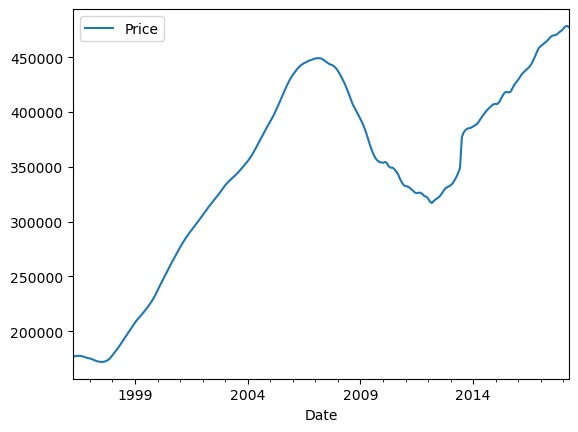

In [179]:
chicago_price.plot();

In [181]:
result_chicago = seasonal_decompose(chicago_price, model='multiplicative') # assume multiplicative model

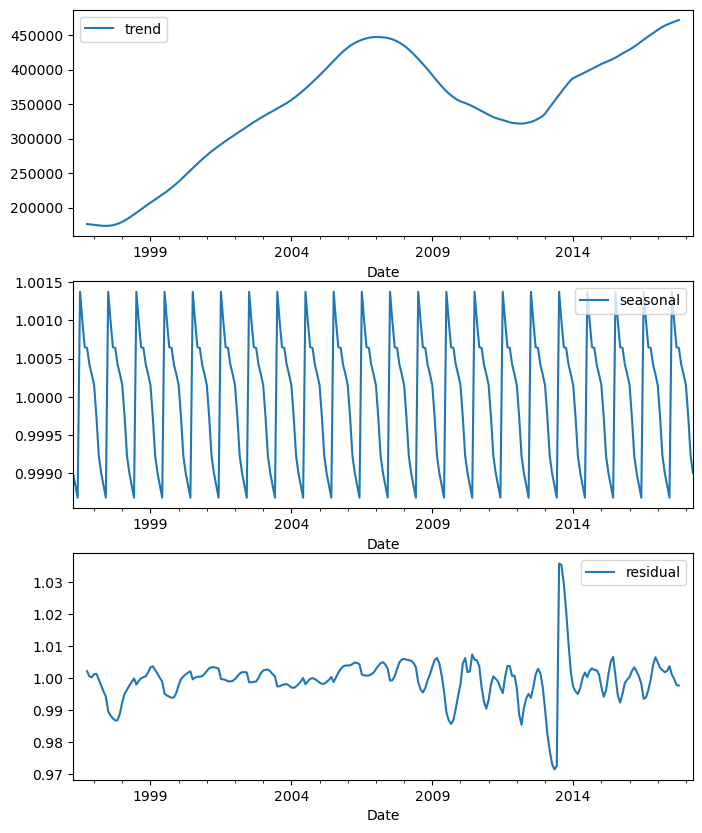

In [182]:
fig, ax = plt.subplots(3,1, figsize = (8,10))
result_chicago.trend.plot(ax = ax[0], label = 'trend')
ax[0].legend()
result_chicago.seasonal.plot(ax = ax[1], label = 'seasonal')
ax[1].legend()
result_chicago.resid.plot(ax = ax[2], label = 'residual')
ax[2].legend();

In [444]:
chicago_zips

,Date,RegionID,RegionName,City,State,Metro,CountyName,SizeRank,Price
0,1996-04-01,84654,60657,Chicago,IL,Chicago,Cook,1,334200.0
1,1996-04-01,84616,60614,Chicago,IL,Chicago,Cook,4,498100.0
2,1996-04-01,84640,60640,Chicago,IL,Chicago,Cook,8,216500.0
3,1996-04-01,84646,60647,Chicago,IL,Chicago,Cook,17,122700.0
4,1996-04-01,84620,60618,Chicago,IL,Chicago,Cook,20,142600.0
...,...,...,...,...,...,...,...,...,...
10860,2018-04-01,84653,60656,Chicago,IL,Chicago,Cook,3157,304000.0
10861,2018-04-01,84652,60655,Chicago,IL,Chicago,Cook,3961,232600.0
10862,2018-04-01,84645,60646,Chicago,IL,Chicago,Cook,4041,401300.0
10863,2018-04-01,399713,60642,Chicago,IL,Chicago,Cook,4363,604400.0


In [129]:
df_chicago['RegionName']

41

# Step 5: ARIMA Modeling

In [ ]:
import matplotlib.pyplot as plt

In [23]:
cook = df_melted[df_melted['CountyName'] =='Cook']

In [24]:
price = cook['Price']

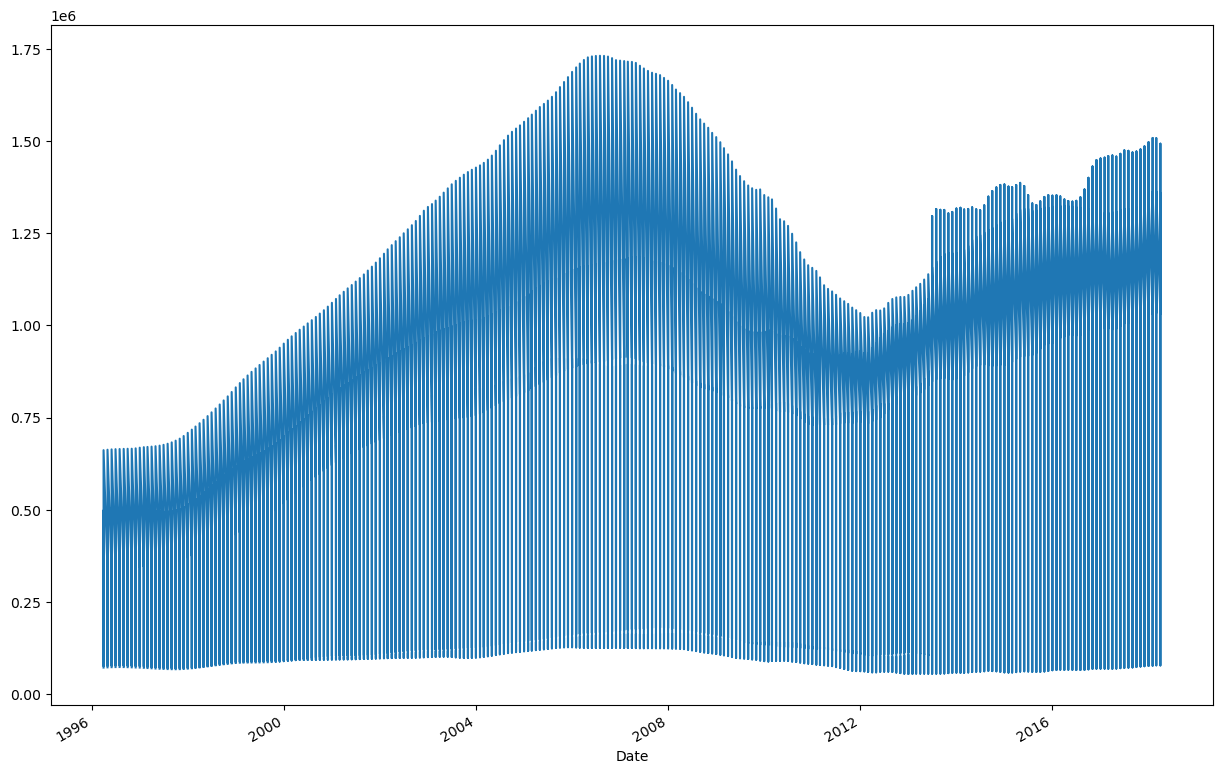

In [31]:
price.plot(kind='line', figsize=(15,10));

In [27]:
df_melted.index

DatetimeIndex(['1996-04-01', '1996-04-01', '1996-04-01', '1996-04-01',
               '1996-04-01', '1996-04-01', '1996-04-01', '1996-04-01',
               '1996-04-01', '1996-04-01',
               ...
               '2018-04-01', '2018-04-01', '2018-04-01', '2018-04-01',
               '2018-04-01', '2018-04-01', '2018-04-01', '2018-04-01',
               '2018-04-01', '2018-04-01'],
              dtype='datetime64[ns]', name='Date', length=3901595, freq=None)

# Step 6: Interpreting Results